In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

# 경고창 보이지 않기
import warnings
warnings.filterwarnings('ignore')
# 그래프 설정
plt.rcParams["figure.figsize"] = (13,4)
%matplotlib inline

In [2]:
df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')
df = pd.concat([df_train.drop('SalePrice', 1), df_test])

# target data

In [3]:
dfy = df_train['SalePrice']
dfy.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

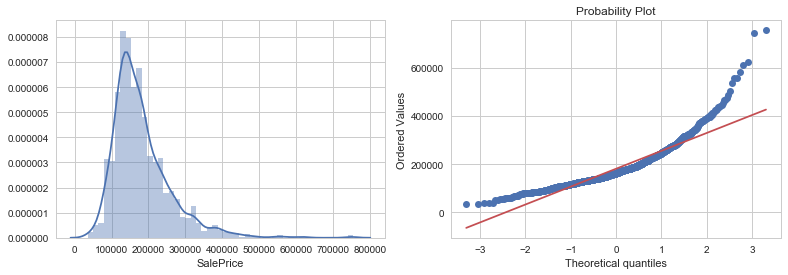

In [4]:
# 시각화
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(121)
sns.distplot(dfy)
## QQ plot
plt.subplot(122)
sp.stats.probplot(dfy, plot=plt)
plt.show()

한쪽으로 치우친 모습을 보임 -> log를 취해 정규분포의 모양에 가깝게 변환

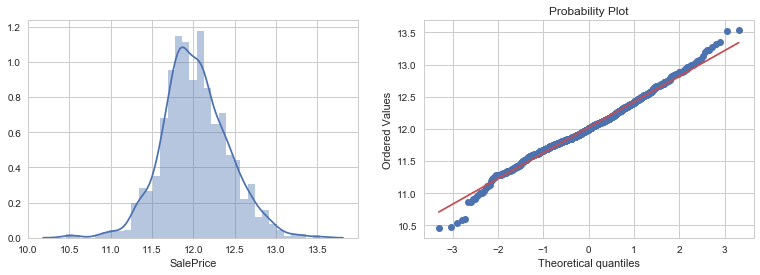

In [5]:
# log 변환
dfy2 = np.log(dfy)

# 시각화
plt.rcParams["figure.figsize"] = (13,4)

plt.subplot(121)
sns.distplot(dfy2)
## QQ plot
plt.subplot(122)
sp.stats.probplot(dfy2, plot=plt)
plt.show()

In [29]:
df_train['SalePrice'] = df_train['SalePrice'].apply(lambda x : np.log(x))

# feature data 확인

- info 함수
- https://goo.gl/19Qkf1 문서 참고

In [6]:
#변수 info 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

## NaN 값 처리

### missing data는 train과 test를 함께  본다

- 카테고리 값 중에서 order가 있는 변수는 숫자로 바꿔서 회귀분석 진행
- nan 값은 해당 항목에 대한 '시설'이 없는 것임으로 점수를 0으로 매겨줌.

nan 값 체크

In [7]:
def nan_check(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 있는 column만 가져옴.
    null_count = null_count.query('NaN > 0')
    return(null_count)

def nan_check2(df_raw):
    null_check = df_raw.isnull().sum()
    null_count = pd.DataFrame({'column' : null_check.index, 'NaN' : null_check.values})
    # None 값이 없는 column만 가져옴.
    null_count = null_count.query('NaN == 0')
    return(null_count)

In [11]:
nan_check(df)

,NaN,column


In [9]:
tonum = {"ExterQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "ExterCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "HeatingQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "KitchenQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "FireplaceQu": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageQual": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "GarageCond": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "PoolQC": {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, np.nan : 0},
         "BsmtFinType1" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
         "BsmtFinType2" : {'GLQ' : 6, 'ALQ' : 5, 'BLQ': 4,'Rec' : 3,'LwQ' : 2, 'Unf' : 1, np.nan : 0},
        }

df= df.replace(tonum)

- nan 값이 '시설 없음'인 변수들에 대해서 'N' 이라는 클래스를 부여해 줌

In [10]:
fill_na_ls = ['GarageType', 'MiscFeature', 'Fence', 'GarageFinish', 'BsmtExposure', 'Alley', 'MasVnrType']

for name in fill_na_ls:
    df[name] = df[name].fillna('N')
    
fill_zero_ls = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'MasVnrArea']

for name in fill_zero_ls:
    df[name] = df[name].fillna(0)
    
fill_mode_ls = ['Electrical', 'Functional', 'MSZoning', 'SaleType', 'Utilities', 'LotFrontage', 'Exterior1st', 'Exterior2nd']
for name in fill_mode_ls:
    df[name] = df[name].fillna(df[name].mode()[0])

In [ ]:
# 참고

cat_ls = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Bsmt가 없음. -> 0 처리
['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'TotalBsmtSF'
]

# 차고없음 0 처리 
[
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
]

# Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , 
# we can fill in missing values by the median LotFrontage of the neighborhood.
# -> 중앙값 처리 -> 일단 최빈값 처리 해봄.
['LotFrontage']

# 없음 : 0처리
[
'MasVnrArea', 'MasVnrType'
]


#따로 의미 없음. 최빈값처리

'Electrical', 'Functional', 'MSZoning', 'SaleType', 'Utilities', 'LotFrontage', 'Exterior1st', 'Exterior2nd'

In [ ]:
# 참고

a = set(nan_check(df).column) - set(cat_ls)
cat_nan_ls = set(nan_check(df).column) - a
cat_nan_ls

In [22]:
# 이걸 하는 이유는 아래에 있음.
df['TotSF'] = df['1stFlrSF'] + df['TotalBsmtSF'] + df['2ndFlrSF']

## DataFrame 다시 분리

In [12]:
df_test = df.iloc[1460:]
df = df.iloc[:1460]
df['SalePrice'] = df_train['SalePrice']

In [17]:
# 변수 살펴보기

# 카테고리 변수
cat_ls = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageCars', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'GarageYrBlt', 'BsmtFullBath', 'BedroomAbvGr', 'MoSold', 'BsmtHalfBath', 'YrSold', 'KitchenAbvGr']
df_cat = df[cat_ls]
df_cat['SalePrice'] = df['SalePrice']

# 실수 변수
num_ls = list(set(df.columns) - set(cat_ls))
num_ls.append('SalePrice')
df_num = df[num_ls]
df_cat['SalePrice'] = df['SalePrice']

## categorical data

In [15]:
def show_viobox(df,col_name):
    print(col_name)
        
    # 각 항목에 대한 빈도 출력 / df2 dataframe 따로 생성
    df2 = pd.DataFrame(df[col_name])
    counts = df2.groupby([col_name]).size().reset_index(name='Counts')
    print(counts)
        
    plt.subplot(121)
    sns.violinplot(x=col_name, y='SalePrice', data=df)
    plt.subplot(122)
    sns.boxplot(x=col_name, y='SalePrice', data=df)
    plt.show()

MSSubClass
    MSSubClass  Counts
0           20     536
1           30      69
2           40       4
3           45      12
4           50     144
5           60     299
6           70      60
7           75      16
8           80      58
9           85      20
10          90      52
11         120      87
12         160      63
13         180      10
14         190      30


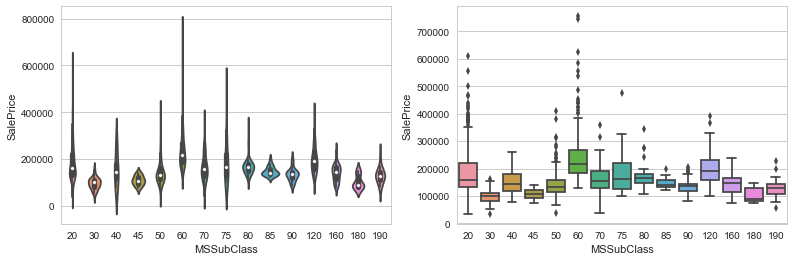

MSZoning
  MSZoning  Counts
0  C (all)      10
1       FV      65
2       RH      16
3       RL    1151
4       RM     218


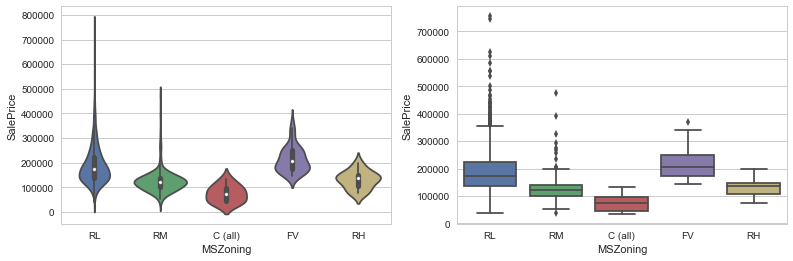

Street
  Street  Counts
0   Grvl       6
1   Pave    1454


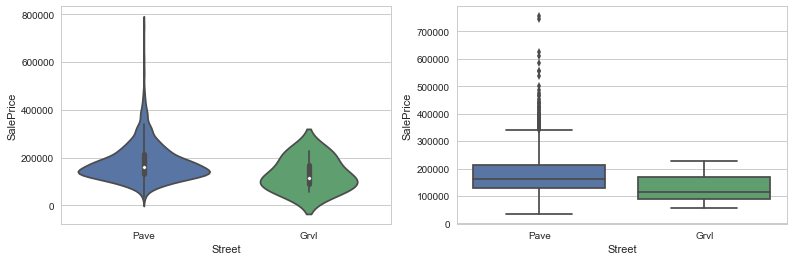

Alley
  Alley  Counts
0  Grvl      50
1     N    1369
2  Pave      41


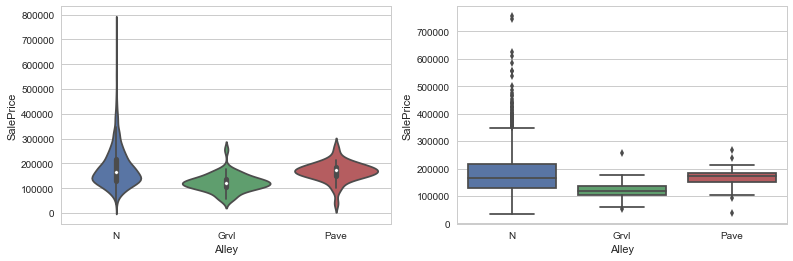

LotShape
  LotShape  Counts
0      IR1     484
1      IR2      41
2      IR3      10
3      Reg     925


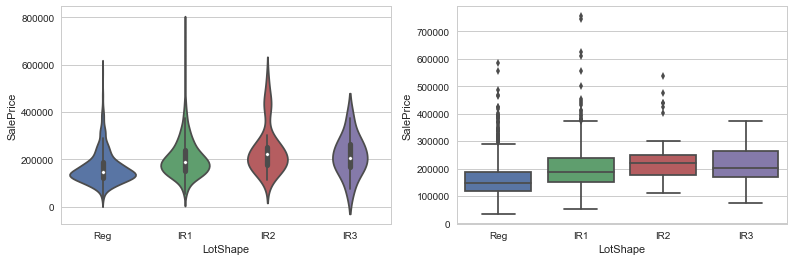

LandContour
  LandContour  Counts
0         Bnk      63
1         HLS      50
2         Low      36
3         Lvl    1311


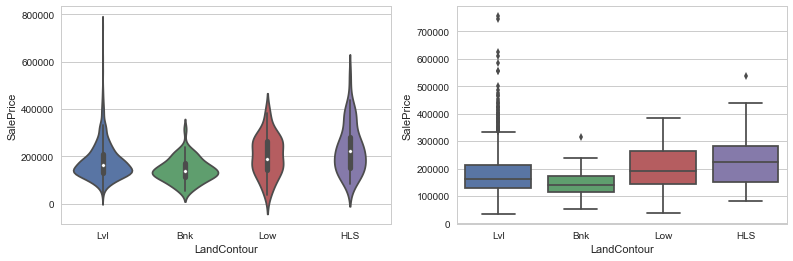

Utilities
  Utilities  Counts
0    AllPub    1459
1    NoSeWa       1


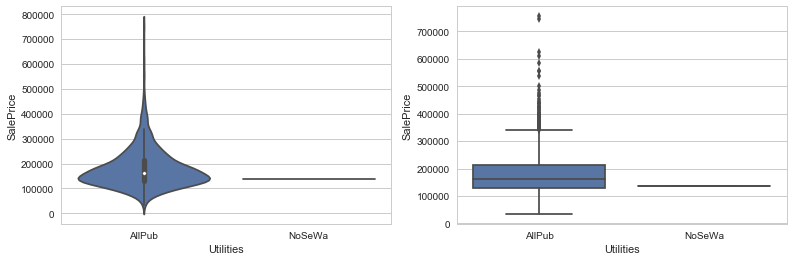

LotConfig
  LotConfig  Counts
0    Corner     263
1   CulDSac      94
2       FR2      47
3       FR3       4
4    Inside    1052


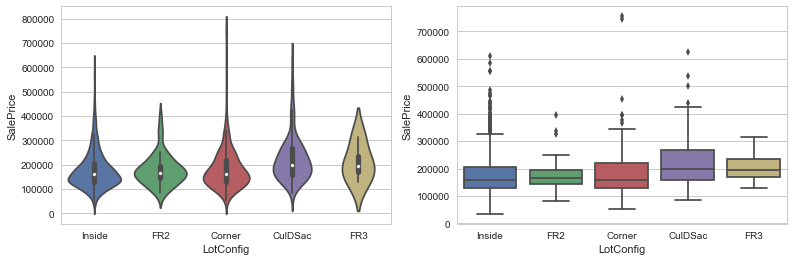

LandSlope
  LandSlope  Counts
0       Gtl    1382
1       Mod      65
2       Sev      13


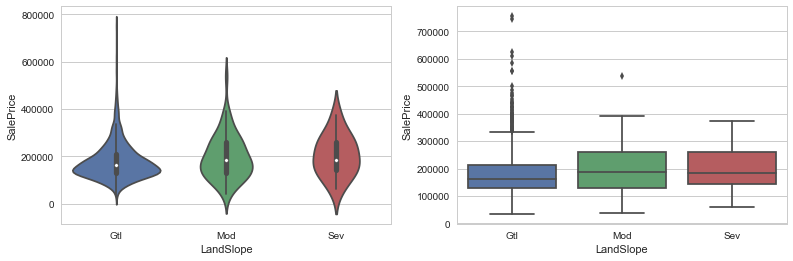

Neighborhood
   Neighborhood  Counts
0       Blmngtn      17
1       Blueste       2
2        BrDale      16
3       BrkSide      58
4       ClearCr      28
5       CollgCr     150
6       Crawfor      51
7       Edwards     100
8       Gilbert      79
9        IDOTRR      37
10      MeadowV      17
11      Mitchel      49
12        NAmes     225
13      NPkVill       9
14       NWAmes      73
15      NoRidge      41
16      NridgHt      77
17      OldTown     113
18        SWISU      25
19       Sawyer      74
20      SawyerW      59
21      Somerst      86
22      StoneBr      25
23       Timber      38
24      Veenker      11


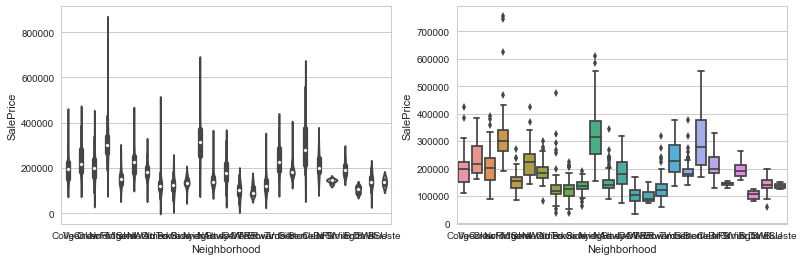

Condition1
  Condition1  Counts
0     Artery      48
1      Feedr      81
2       Norm    1260
3       PosA       8
4       PosN      19
5       RRAe      11
6       RRAn      26
7       RRNe       2
8       RRNn       5


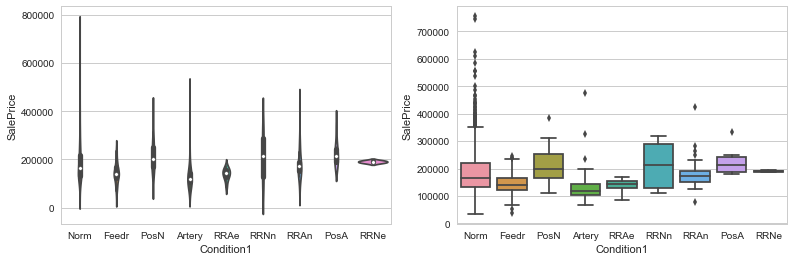

Condition2
  Condition2  Counts
0     Artery       2
1      Feedr       6
2       Norm    1445
3       PosA       1
4       PosN       2
5       RRAe       1
6       RRAn       1
7       RRNn       2


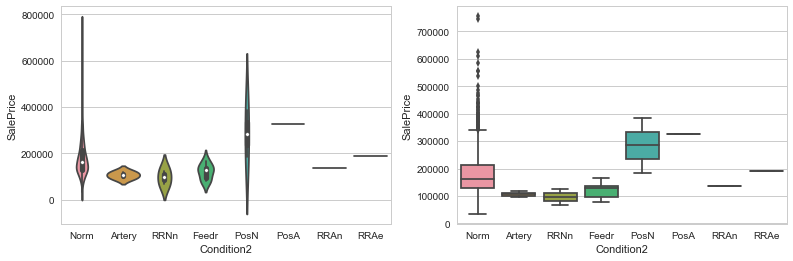

BldgType
  BldgType  Counts
0     1Fam    1220
1   2fmCon      31
2   Duplex      52
3    Twnhs      43
4   TwnhsE     114


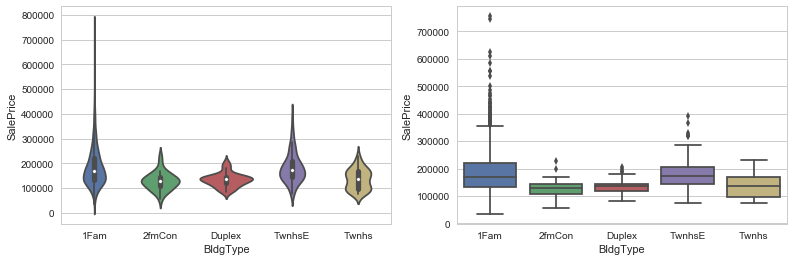

HouseStyle
  HouseStyle  Counts
0     1.5Fin     154
1     1.5Unf      14
2     1Story     726
3     2.5Fin       8
4     2.5Unf      11
5     2Story     445
6     SFoyer      37
7       SLvl      65


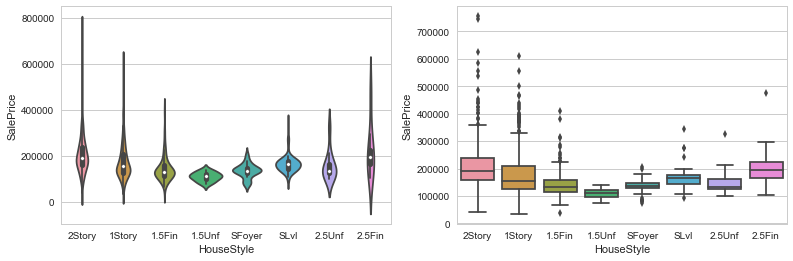

OverallQual
   OverallQual  Counts
0            1       2
1            2       3
2            3      20
3            4     116
4            5     397
5            6     374
6            7     319
7            8     168
8            9      43
9           10      18


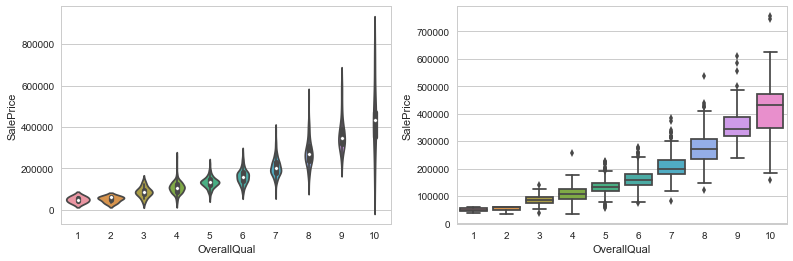

OverallCond
   OverallCond  Counts
0            1       1
1            2       5
2            3      25
3            4      57
4            5     821
5            6     252
6            7     205
7            8      72
8            9      22


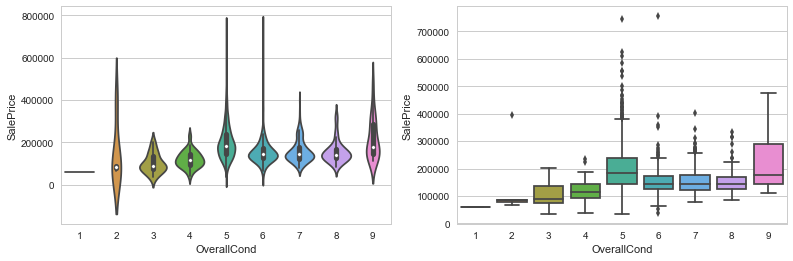

RoofStyle
  RoofStyle  Counts
0      Flat      13
1     Gable    1141
2   Gambrel      11
3       Hip     286
4   Mansard       7
5      Shed       2


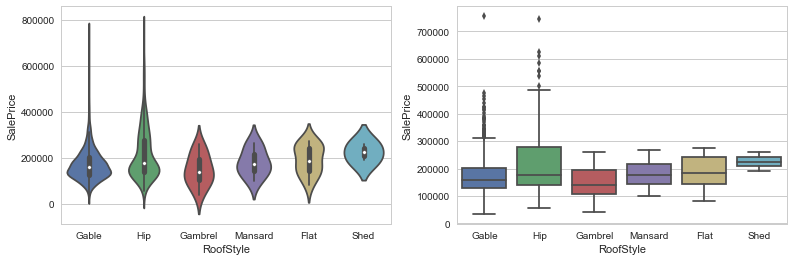

RoofMatl
  RoofMatl  Counts
0  ClyTile       1
1  CompShg    1434
2  Membran       1
3    Metal       1
4     Roll       1
5  Tar&Grv      11
6  WdShake       5
7  WdShngl       6


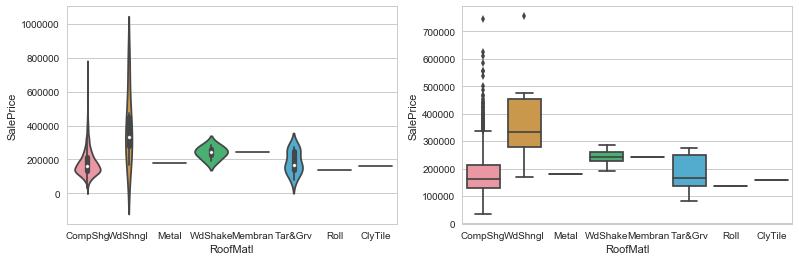

Exterior1st
   Exterior1st  Counts
0      AsbShng      20
1      AsphShn       1
2      BrkComm       2
3      BrkFace      50
4       CBlock       1
5      CemntBd      61
6      HdBoard     222
7      ImStucc       1
8      MetalSd     220
9      Plywood     108
10       Stone       2
11      Stucco      25
12     VinylSd     515
13     Wd Sdng     206
14     WdShing      26


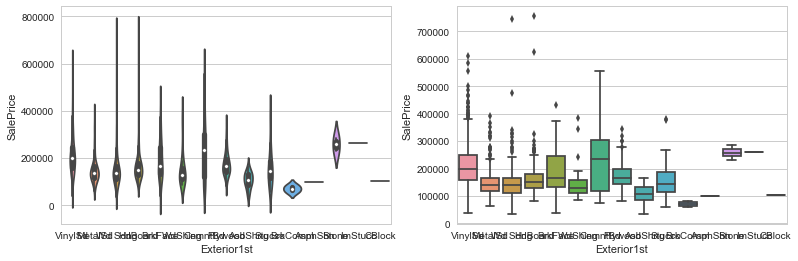

Exterior2nd
   Exterior2nd  Counts
0      AsbShng      20
1      AsphShn       3
2      Brk Cmn       7
3      BrkFace      25
4       CBlock       1
5      CmentBd      60
6      HdBoard     207
7      ImStucc      10
8      MetalSd     214
9        Other       1
10     Plywood     142
11       Stone       5
12      Stucco      26
13     VinylSd     504
14     Wd Sdng     197
15     Wd Shng      38


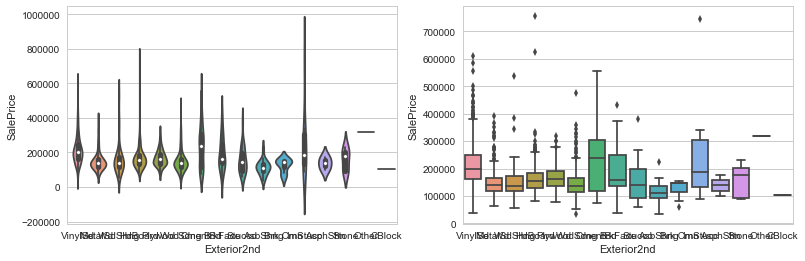

MasVnrType
  MasVnrType  Counts
0          0       8
1     BrkCmn      15
2    BrkFace     445
3       None     864
4      Stone     128


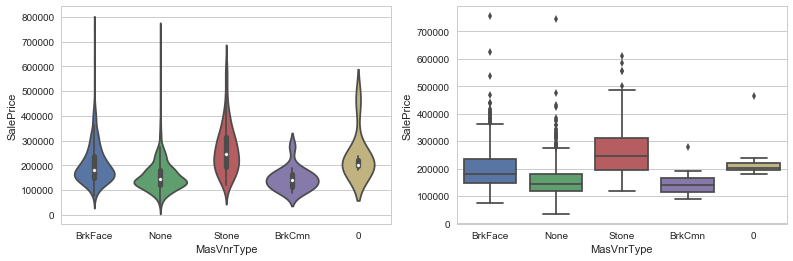

ExterQual
   ExterQual  Counts
0          2      14
1          3     906
2          4     488
3          5      52


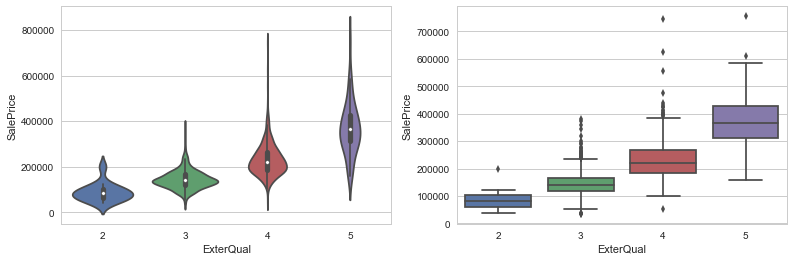

ExterCond
   ExterCond  Counts
0          1       1
1          2      28
2          3    1282
3          4     146
4          5       3


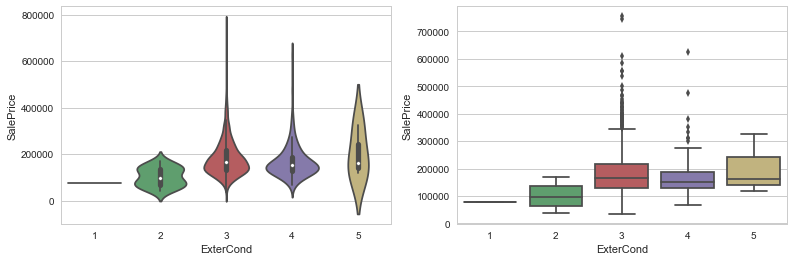

Foundation
  Foundation  Counts
0     BrkTil     146
1     CBlock     634
2      PConc     647
3       Slab      24
4      Stone       6
5       Wood       3


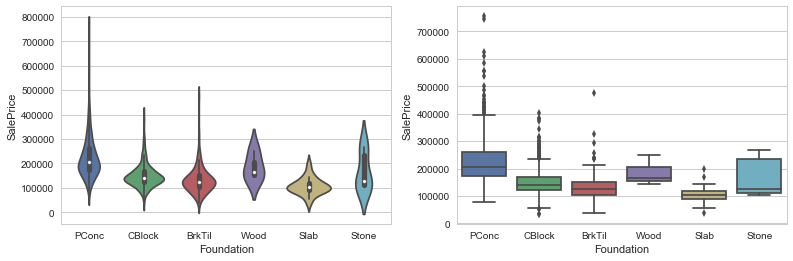

BsmtQual
   BsmtQual  Counts
0         0      37
1         2      35
2         3     649
3         4     618
4         5     121


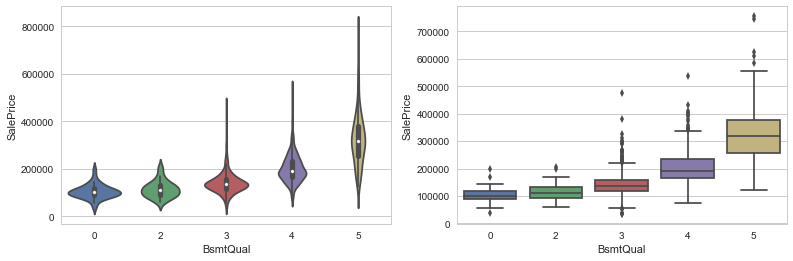

BsmtCond
   BsmtCond  Counts
0         0      37
1         1       2
2         2      45
3         3    1311
4         4      65


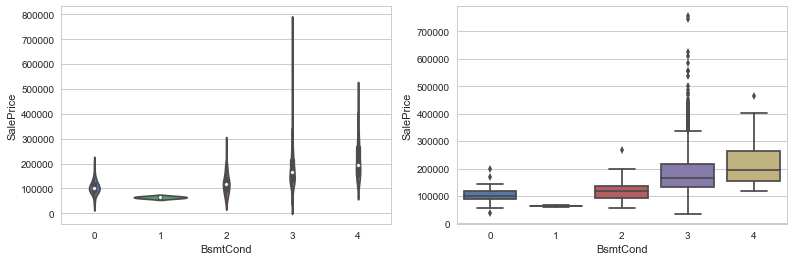

BsmtExposure
  BsmtExposure  Counts
0           Av     221
1           Gd     134
2           Mn     114
3            N      38
4           No     953


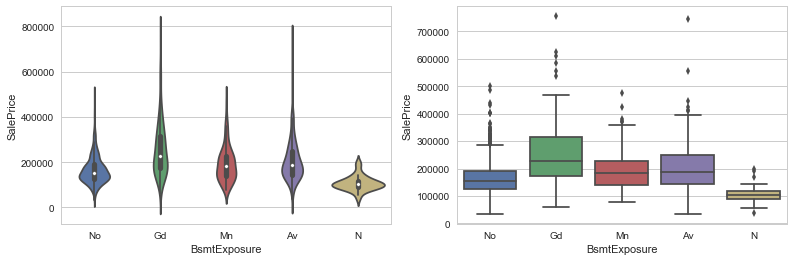

BsmtFinType1
   BsmtFinType1  Counts
0             0      37
1             1     430
2             2      74
3             3     133
4             4     148
5             5     220
6             6     418


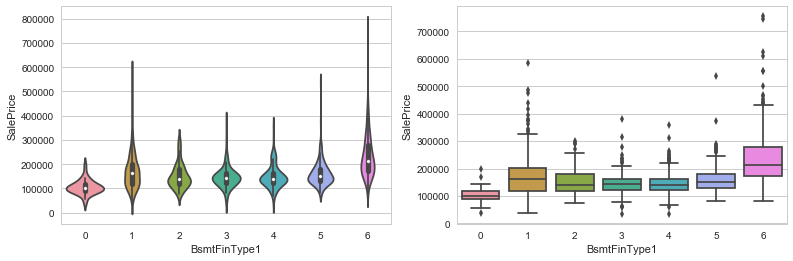

BsmtFinType2
   BsmtFinType2  Counts
0             0      38
1             1    1256
2             2      46
3             3      54
4             4      33
5             5      19
6             6      14


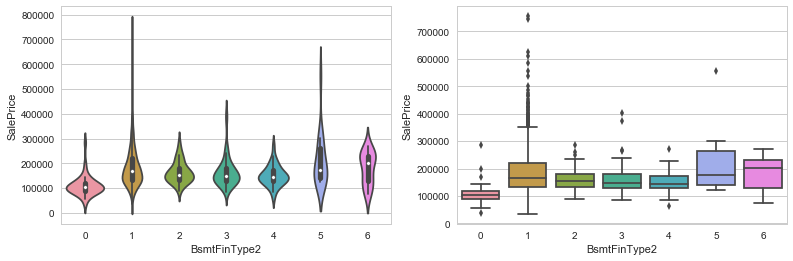

Heating
  Heating  Counts
0   Floor       1
1    GasA    1428
2    GasW      18
3    Grav       7
4    OthW       2
5    Wall       4


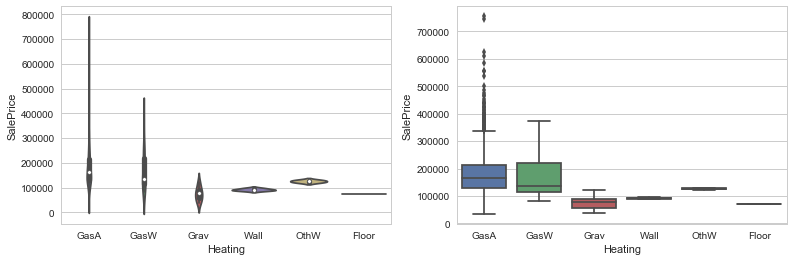

HeatingQC
   HeatingQC  Counts
0          1       1
1          2      49
2          3     428
3          4     241
4          5     741


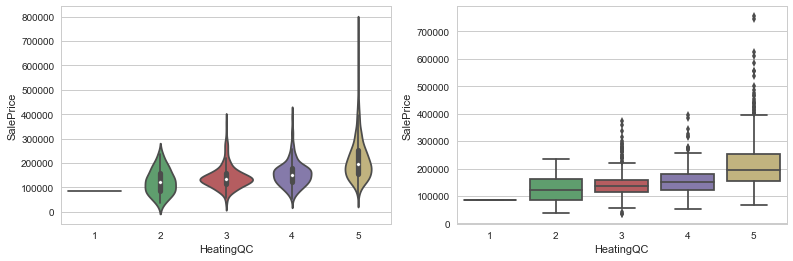

CentralAir
  CentralAir  Counts
0          N      95
1          Y    1365


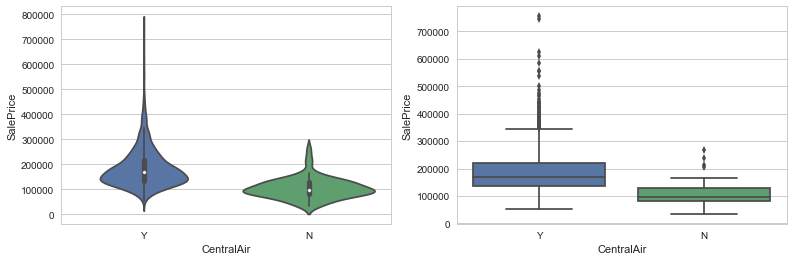

Electrical
  Electrical  Counts
0      FuseA      94
1      FuseF      27
2      FuseP       3
3        Mix       1
4      SBrkr    1335


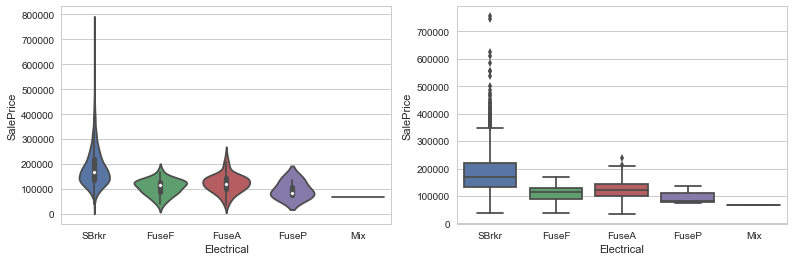

KitchenQual
   KitchenQual  Counts
0            2      39
1            3     735
2            4     586
3            5     100


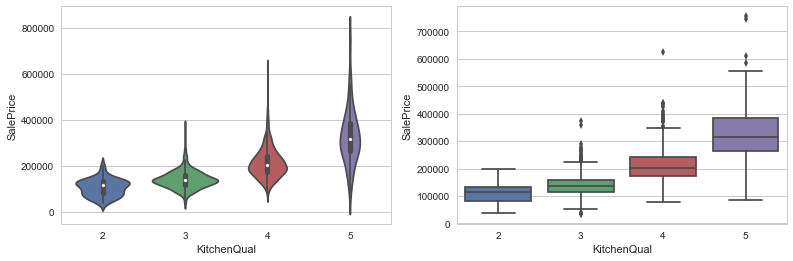

Functional
  Functional  Counts
0       Maj1      14
1       Maj2       5
2       Min1      31
3       Min2      34
4        Mod      15
5        Sev       1
6        Typ    1360


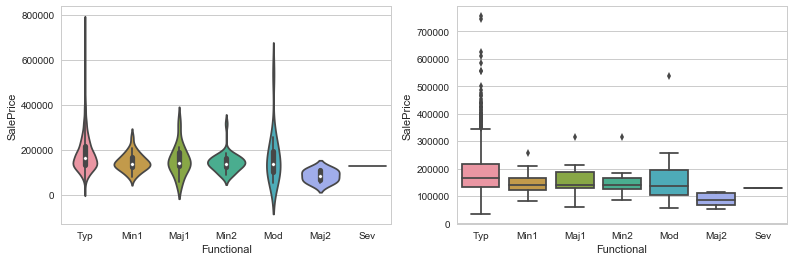

FireplaceQu
   FireplaceQu  Counts
0            0     690
1            1      20
2            2      33
3            3     313
4            4     380
5            5      24


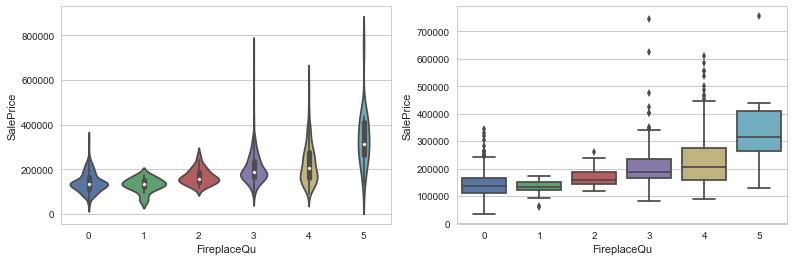

GarageType
  GarageType  Counts
0     2Types       6
1     Attchd     870
2    Basment      19
3    BuiltIn      88
4    CarPort       9
5     Detchd     387
6          N      81


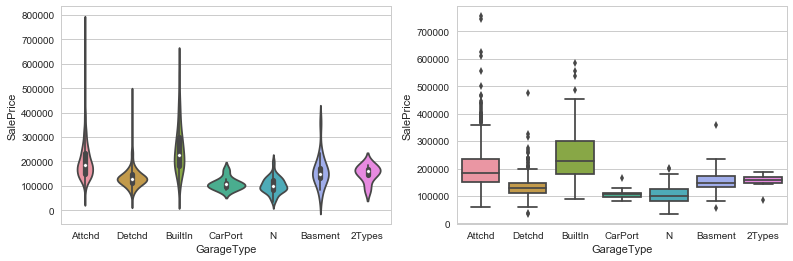

GarageFinish
  GarageFinish  Counts
0          Fin     352
1            N      81
2          RFn     422
3          Unf     605


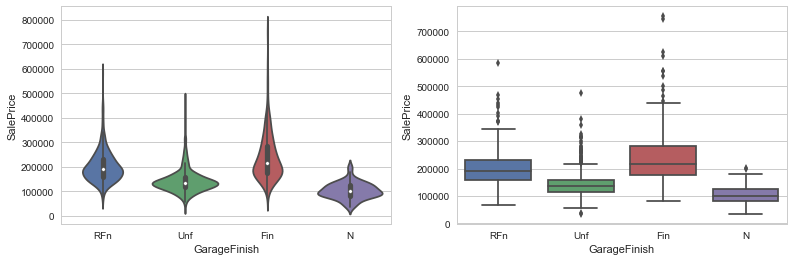

GarageQual
   GarageQual  Counts
0           0      81
1           1       3
2           2      48
3           3    1311
4           4      14
5           5       3


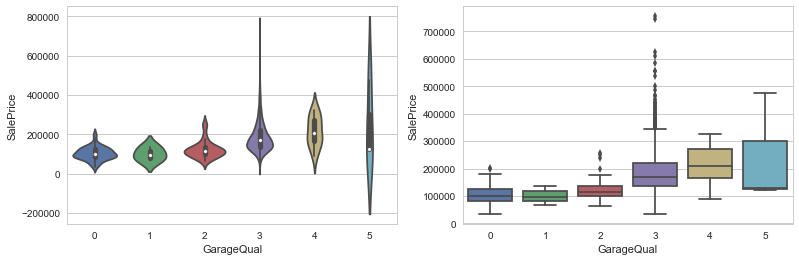

GarageCond
   GarageCond  Counts
0           0      81
1           1       7
2           2      35
3           3    1326
4           4       9
5           5       2


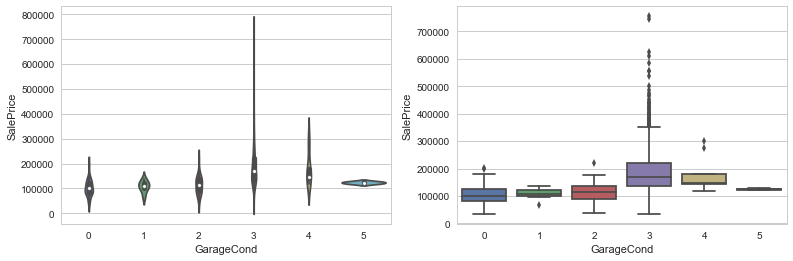

PavedDrive
  PavedDrive  Counts
0          N      90
1          P      30
2          Y    1340


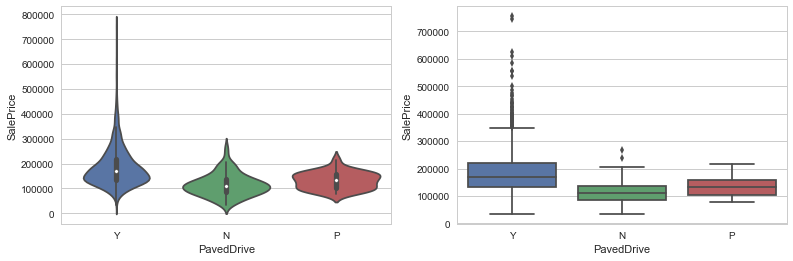

PoolQC
   PoolQC  Counts
0       0    1453
1       2       2
2       4       3
3       5       2


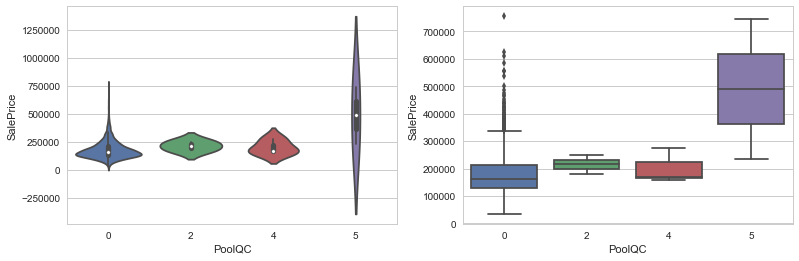

Fence
   Fence  Counts
0  GdPrv      59
1   GdWo      54
2  MnPrv     157
3   MnWw      11
4      N    1179


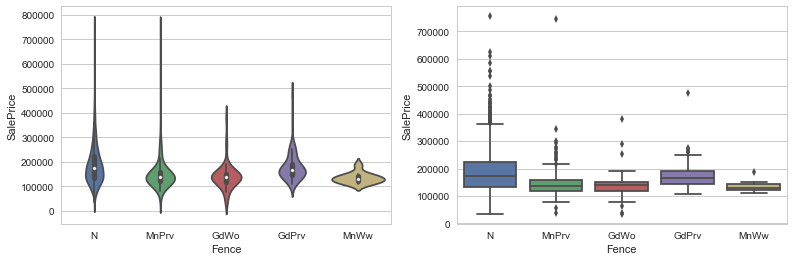

MiscFeature
  MiscFeature  Counts
0        Gar2       2
1           N    1406
2        Othr       2
3        Shed      49
4        TenC       1


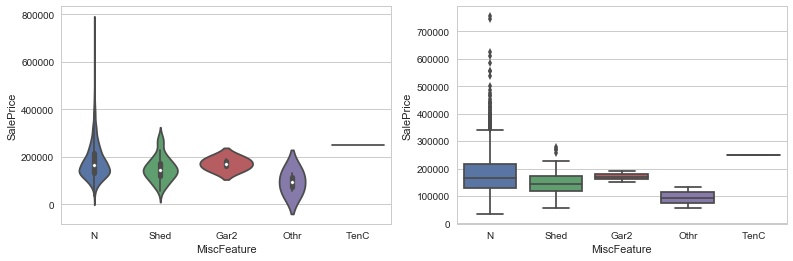

SaleType
  SaleType  Counts
0      COD      43
1      CWD       4
2      Con       2
3    ConLD       9
4    ConLI       5
5    ConLw       5
6      New     122
7      Oth       3
8       WD    1267


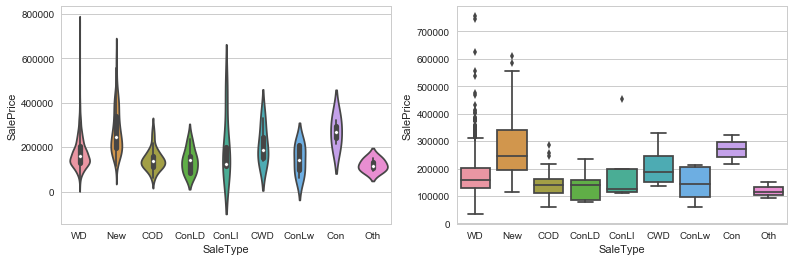

SaleCondition
  SaleCondition  Counts
0       Abnorml     101
1       AdjLand       4
2        Alloca      12
3        Family      20
4        Normal    1198
5       Partial     125


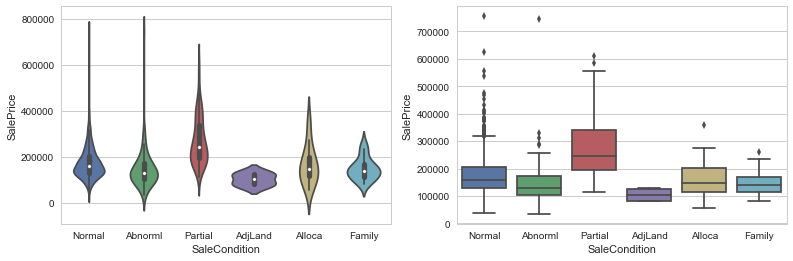

GarageCars
   GarageCars  Counts
0         0.0      81
1         1.0     369
2         2.0     824
3         3.0     181
4         4.0       5


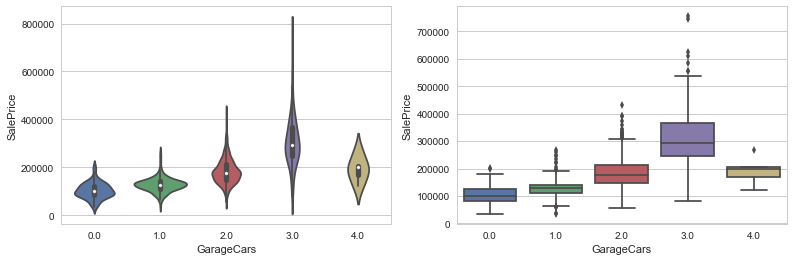

FullBath
   FullBath  Counts
0         0       9
1         1     650
2         2     768
3         3      33


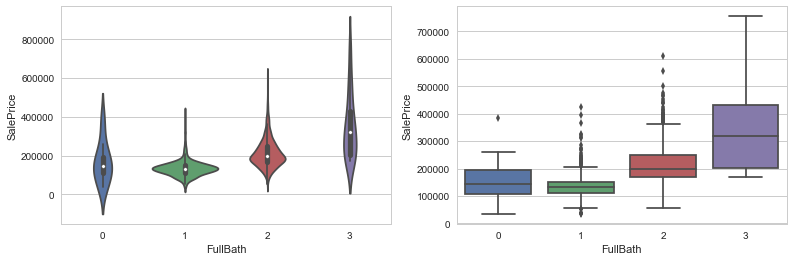

TotRmsAbvGrd
    TotRmsAbvGrd  Counts
0              2       1
1              3      17
2              4      97
3              5     275
4              6     402
5              7     329
6              8     187
7              9      75
8             10      47
9             11      18
10            12      11
11            14       1


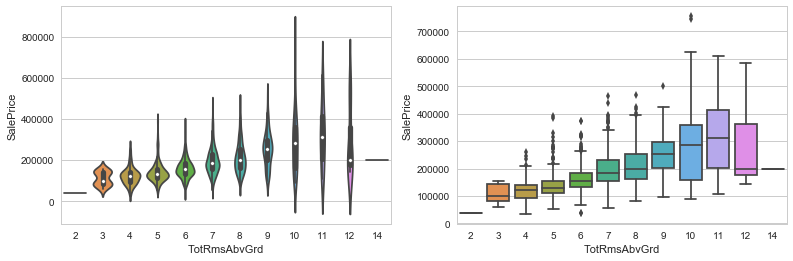

YearBuilt
     YearBuilt  Counts
0         1872       1
1         1875       1
2         1880       4
3         1882       1
4         1885       2
5         1890       2
6         1892       2
7         1893       1
8         1898       1
9         1900      10
10        1904       1
11        1905       1
12        1906       1
13        1908       2
14        1910      17
15        1911       1
16        1912       3
17        1913       1
18        1914       7
19        1915      10
20        1916       8
21        1917       1
22        1918       7
23        1919       3
24        1920      30
25        1921       6
26        1922       8
27        1923       7
28        1924       7
29        1925      16
..         ...     ...
82        1981       5
83        1982       6
84        1983       4
85        1984       9
86        1985       5
87        1986       5
88        1987       3
89        1988      11
90        1989       3
91        1990      12
92        1991       5
9

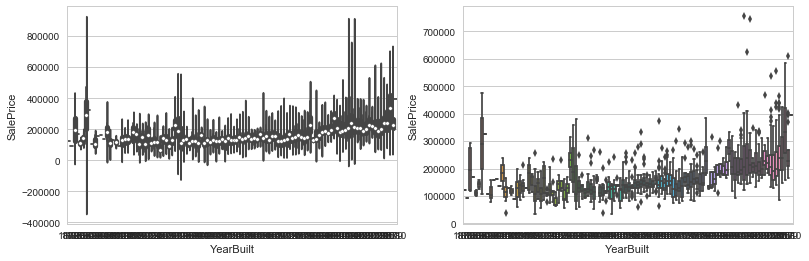

YearRemodAdd
    YearRemodAdd  Counts
0           1950     178
1           1951       4
2           1952       5
3           1953      10
4           1954      14
5           1955       9
6           1956      10
7           1957       9
8           1958      15
9           1959      18
10          1960      12
11          1961       8
12          1962      14
13          1963      13
14          1964      11
15          1965      19
16          1966      15
17          1967      12
18          1968      17
19          1969      14
20          1970      26
21          1971      18
22          1972      20
23          1973      11
24          1974       7
25          1975      10
26          1976      30
27          1977      25
28          1978      16
29          1979      10
..           ...     ...
31          1981       8
32          1982       7
33          1983       5
34          1984       7
35          1985       9
36          1986       5
37          1987      10
38          

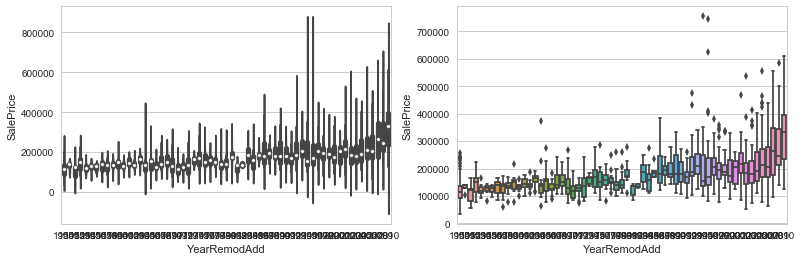

Fireplaces
   Fireplaces  Counts
0           0     690
1           1     650
2           2     115
3           3       5


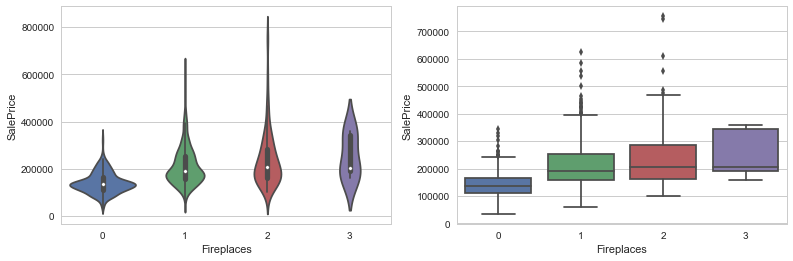

GarageYrBlt
    GarageYrBlt  Counts
0           0.0      81
1        1900.0       1
2        1906.0       1
3        1908.0       1
4        1910.0       3
5        1914.0       2
6        1915.0       2
7        1916.0       5
8        1918.0       2
9        1920.0      14
10       1921.0       3
11       1922.0       5
12       1923.0       3
13       1924.0       3
14       1925.0      10
15       1926.0       6
16       1927.0       1
17       1928.0       4
18       1929.0       2
19       1930.0       8
20       1931.0       4
21       1932.0       3
22       1933.0       1
23       1934.0       2
24       1935.0       4
25       1936.0       5
26       1937.0       2
27       1938.0       3
28       1939.0       9
29       1940.0      14
..          ...     ...
68       1981.0      10
69       1982.0       4
70       1983.0       7
71       1984.0       8
72       1985.0      10
73       1986.0       6
74       1987.0      11
75       1988.0      14
76       1989.0      10
77  

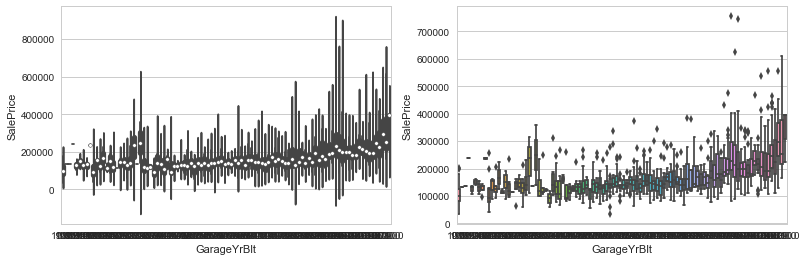

BsmtFullBath
   BsmtFullBath  Counts
0           0.0     856
1           1.0     588
2           2.0      15
3           3.0       1


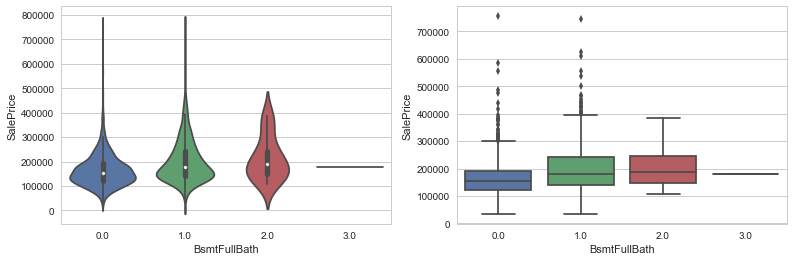

BedroomAbvGr
   BedroomAbvGr  Counts
0             0       6
1             1      50
2             2     358
3             3     804
4             4     213
5             5      21
6             6       7
7             8       1


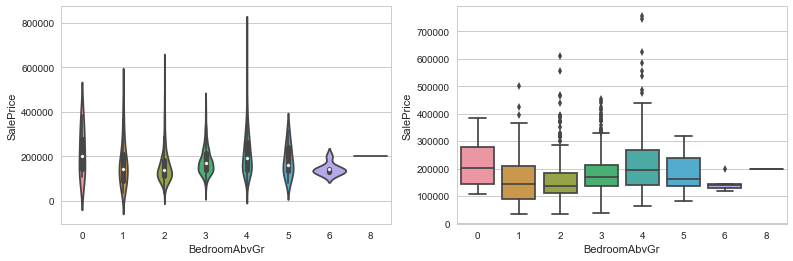

MoSold
    MoSold  Counts
0        1      58
1        2      52
2        3     106
3        4     141
4        5     204
5        6     253
6        7     234
7        8     122
8        9      63
9       10      89
10      11      79
11      12      59


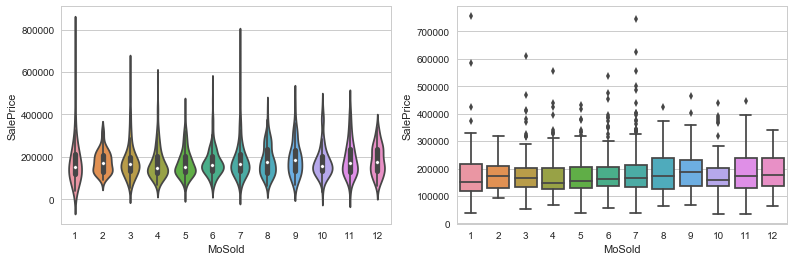

BsmtHalfBath
   BsmtHalfBath  Counts
0           0.0    1378
1           1.0      80
2           2.0       2


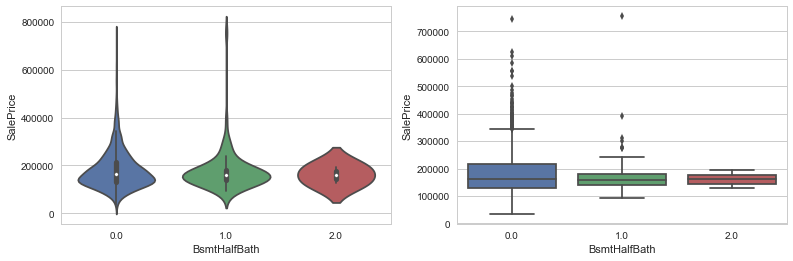

YrSold
   YrSold  Counts
0    2006     314
1    2007     329
2    2008     304
3    2009     338
4    2010     175


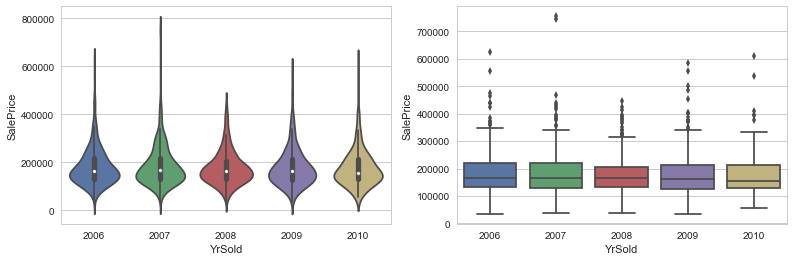

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


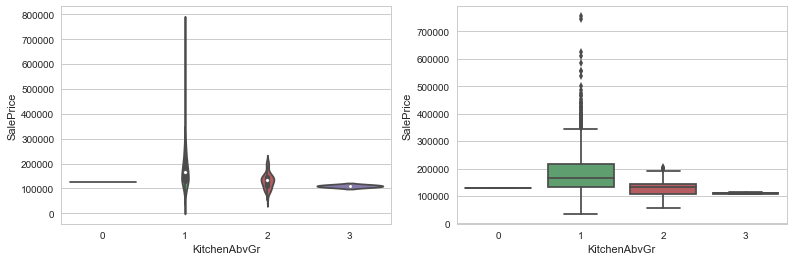

In [18]:
plt.rcParams["figure.figsize"] = (13,4)
for col in cat_ls:
    show_viobox(df, col)

### corr 높은 순서대로 numeric data에 대한 scatter plot 그려봄

<  SalePrice  >
1.0


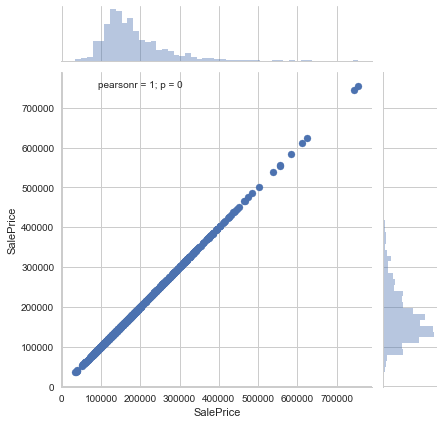

<  GrLivArea  >
0.7086244776126511


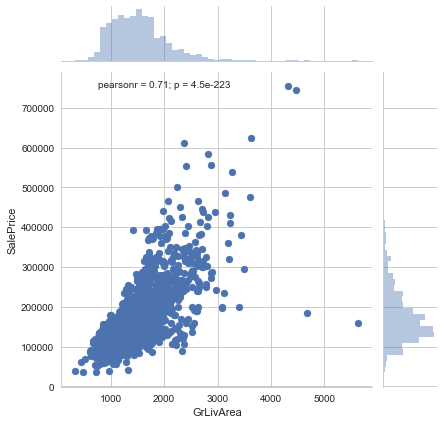

<  GarageArea  >
0.6234314389183598


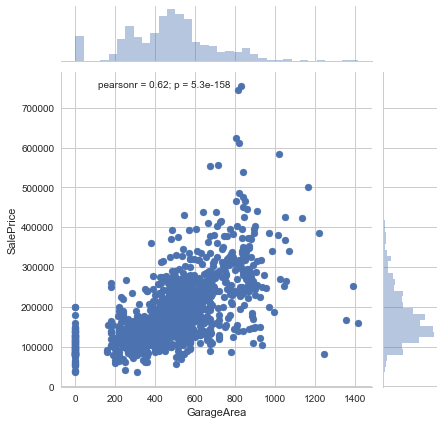

<  TotalBsmtSF  >
0.6135805515591944


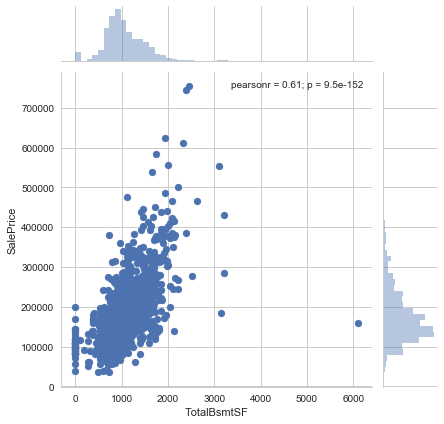

<  1stFlrSF  >
0.6058521846919166


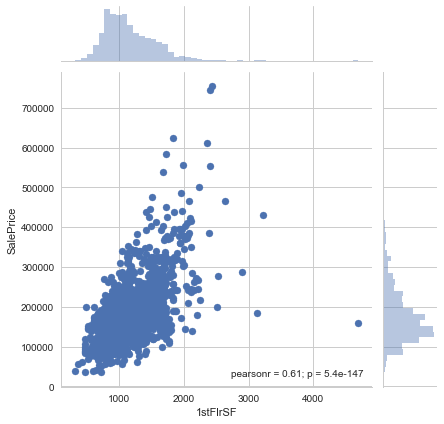

<  MasVnrArea  >
0.47261449900457725


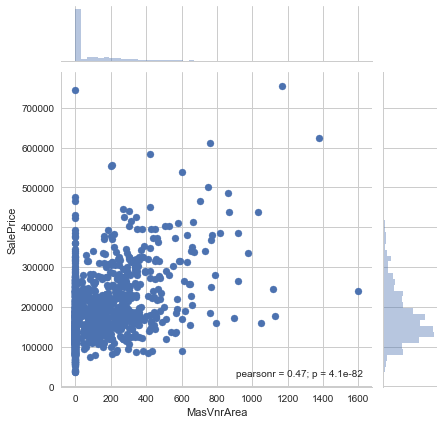

<  BsmtFinSF1  >
0.38641980624215627


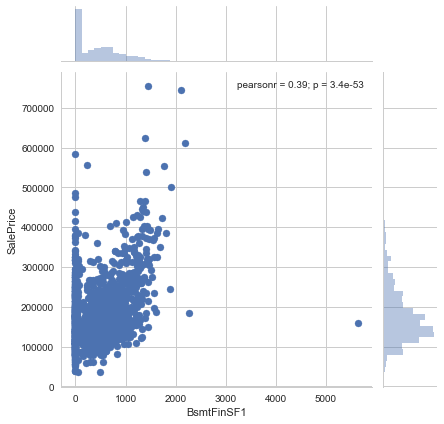

<  LotFrontage  >
0.3292204483832928


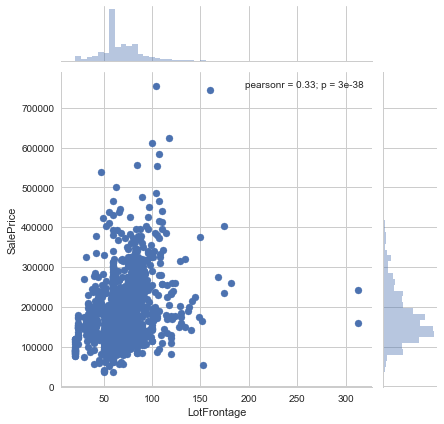

<  WoodDeckSF  >
0.32441344456813076


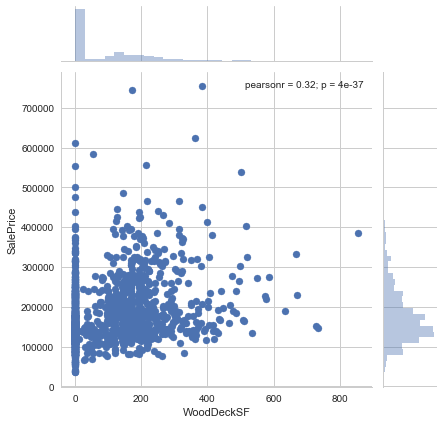

<  2ndFlrSF  >
0.31933380283206614


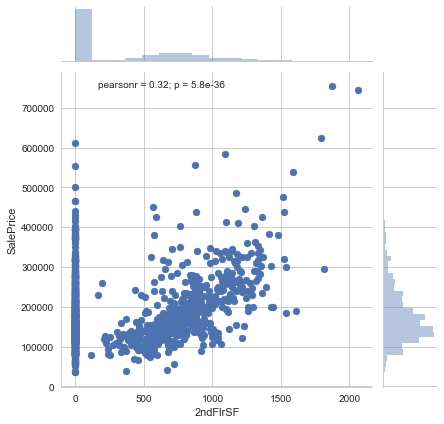

<  OpenPorchSF  >
0.31585622711605577


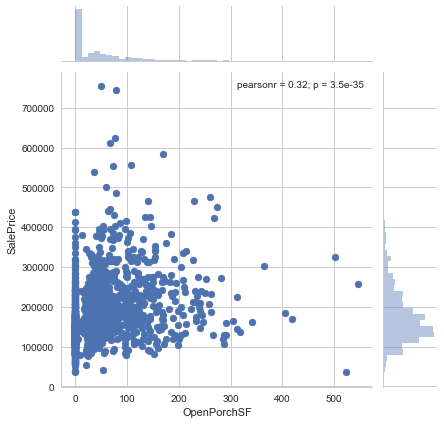

<  HalfBath  >
0.2841076755947784


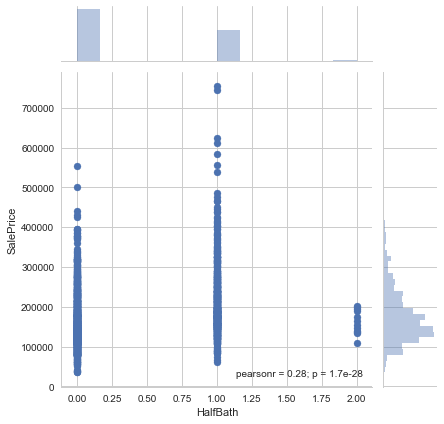

<  LotArea  >
0.2638433538714063


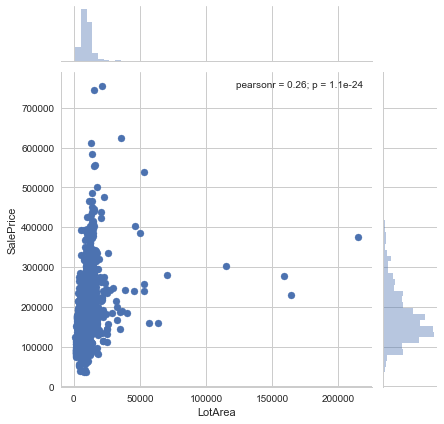

<  BsmtUnfSF  >
0.214479105546969


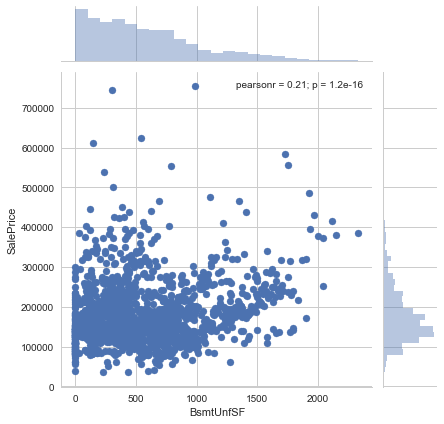

<  ScreenPorch  >
0.11144657114291048


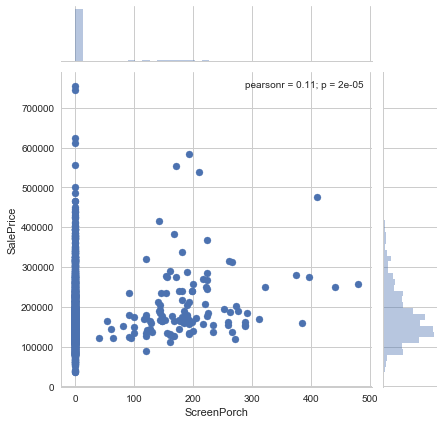

<  PoolArea  >
0.09240354949187278


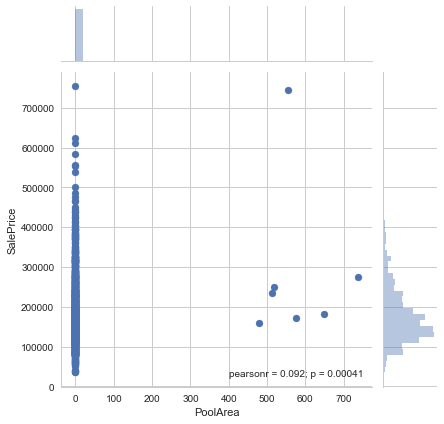

<  3SsnPorch  >
0.04458366533574792


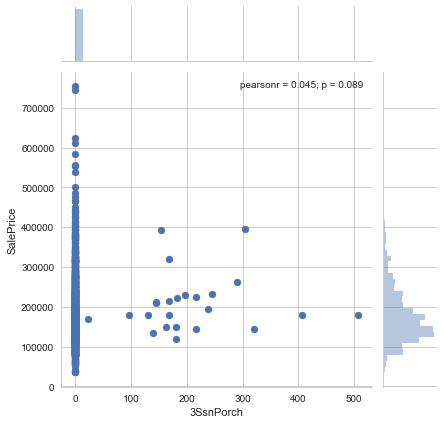

<  BsmtFinSF2  >
-0.011378121450215216


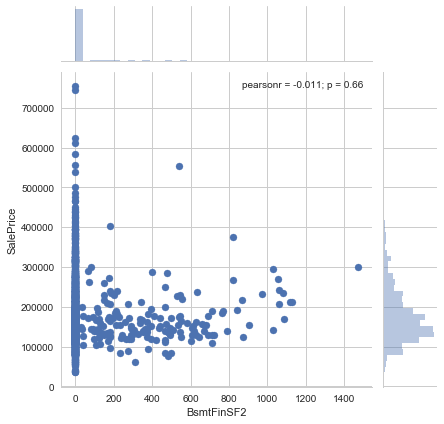

<  MiscVal  >
-0.02118957964030379


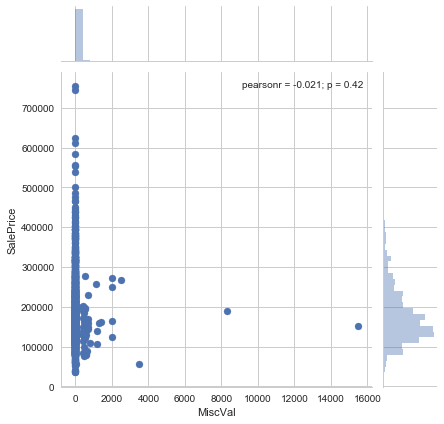

<  Id  >
-0.021916719443431112


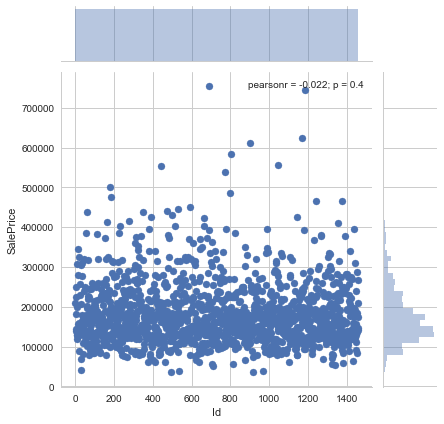

<  LowQualFinSF  >
-0.02560613000068015


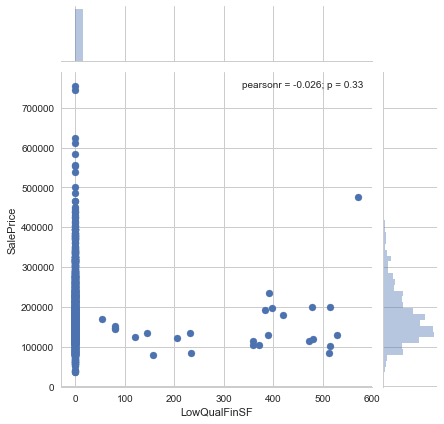

<  EnclosedPorch  >
-0.12857795792595636


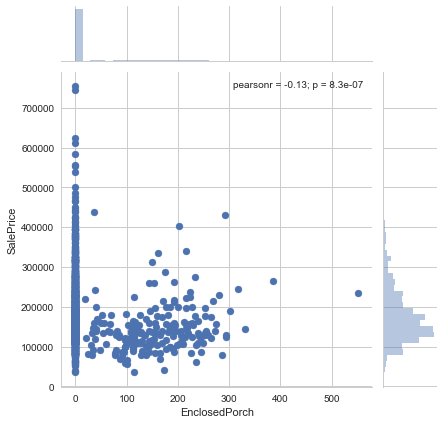

In [19]:
corr = df.corr()['SalePrice']
df_corr = pd.DataFrame({"col" : num_ls})
df_corr['corr'] = df_corr['col'].apply(lambda x : corr[x])
df_corr.sort_values('corr', ascending=False, inplace=True)
num_ls2 = df_corr['col'].values

for col_name in num_ls2:
    print("< ",col_name," >")
    print(corr[col_name])
    sns.jointplot(x=col_name, y="SalePrice", data=df)
    plt.show()


<  SalePrice  >
1.0


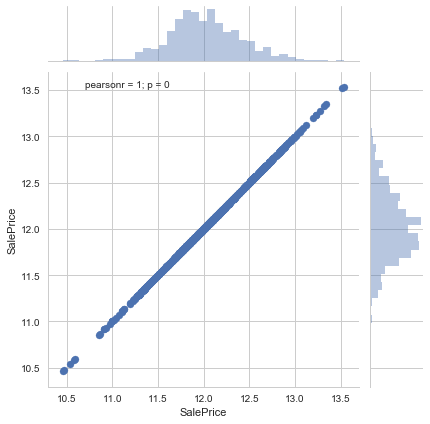

<  GrLivArea  >
0.7009266525441293


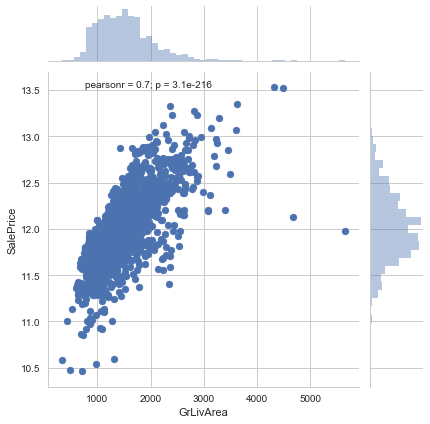

<  GarageArea  >
0.6508875559020062


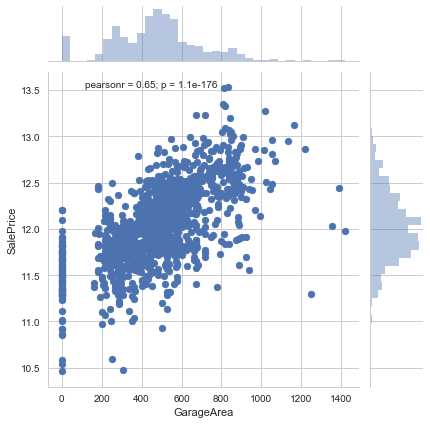

<  TotalBsmtSF  >
0.6121339753697865


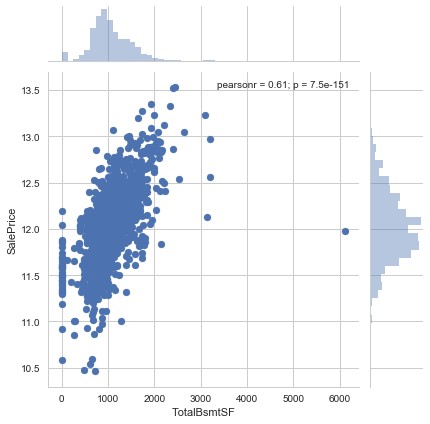

<  1stFlrSF  >
0.596981045034374


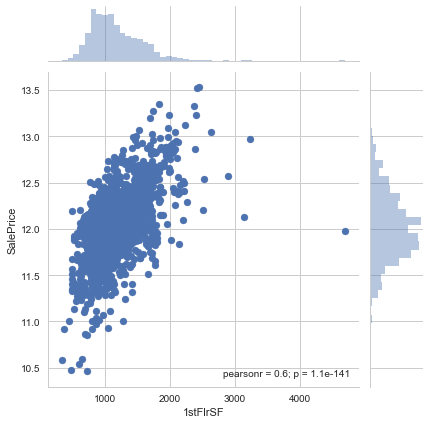

<  MasVnrArea  >
0.42677513183636906


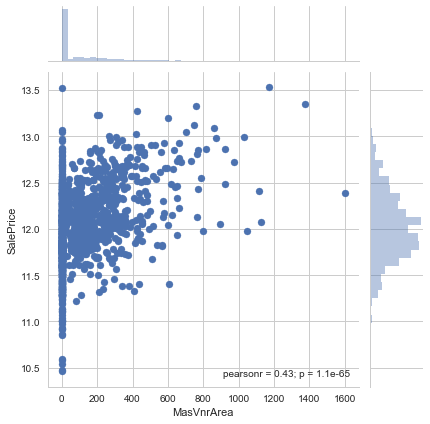

<  BsmtFinSF1  >
0.3720230735670904


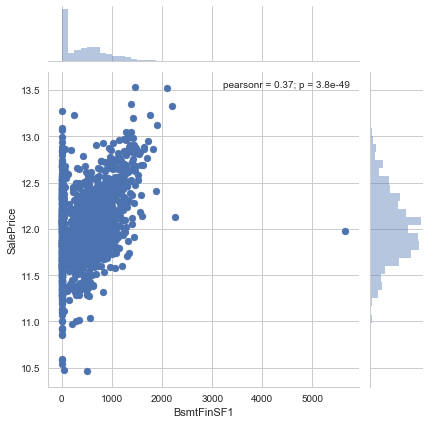

<  WoodDeckSF  >
0.3341350739575136


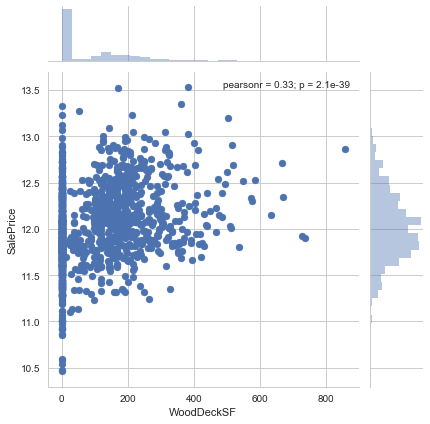

<  LotFrontage  >
0.3235342879004603


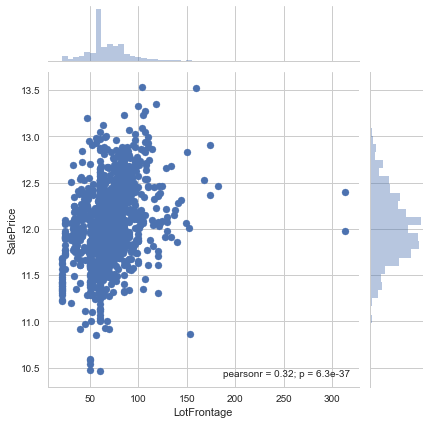

<  OpenPorchSF  >
0.3210529720197666


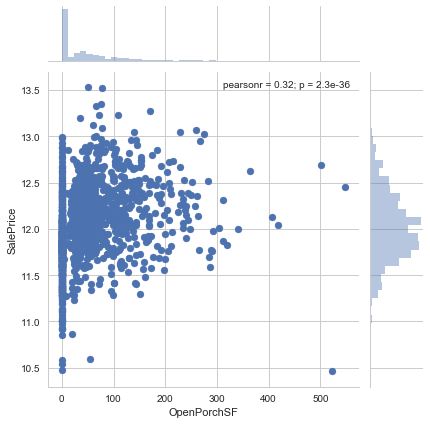

<  2ndFlrSF  >
0.3192999843472038


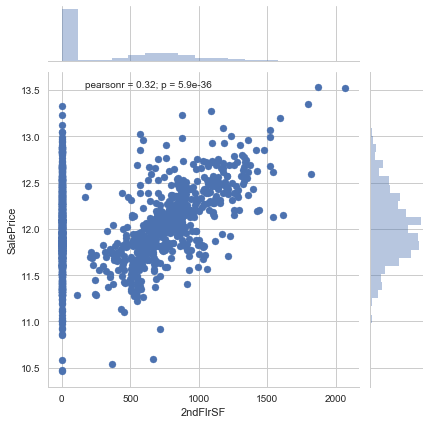

<  HalfBath  >
0.3139822499151441


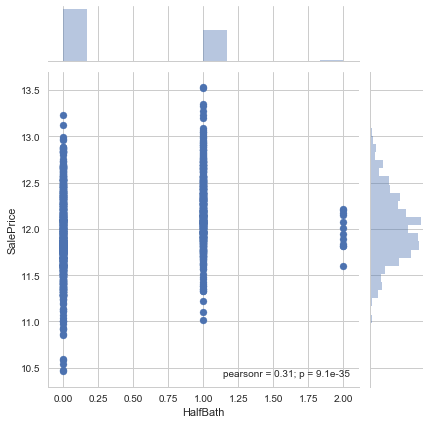

<  LotArea  >
0.25731989235273833


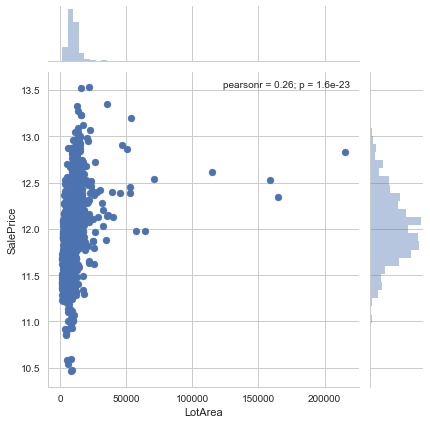

<  BsmtUnfSF  >
0.22198505352520953


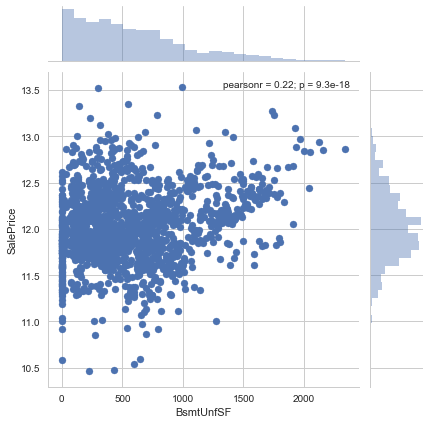

<  ScreenPorch  >
0.12120760489686298


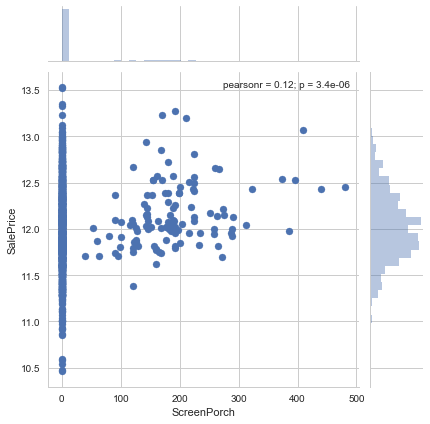

<  PoolArea  >
0.06979780600969131


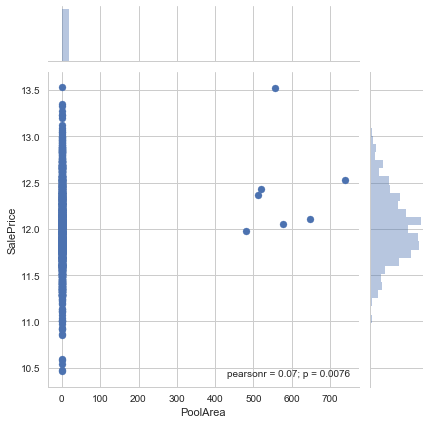

<  3SsnPorch  >
0.05490022646761992


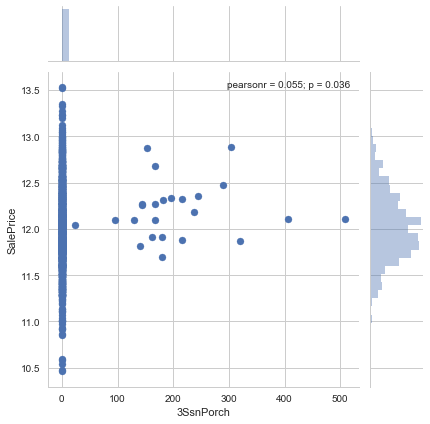

<  BsmtFinSF2  >
0.0048324105320466755


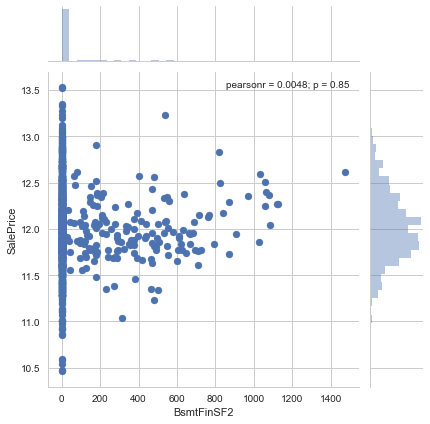

<  Id  >
-0.017942382438871578


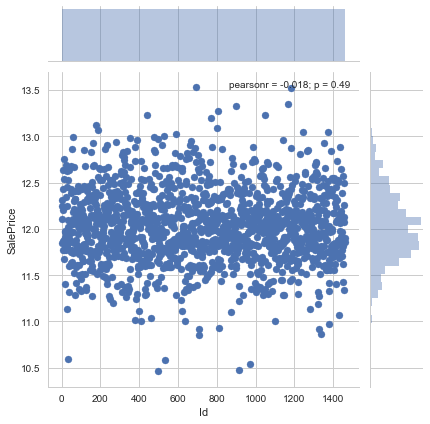

<  MiscVal  >
-0.020020820155023815


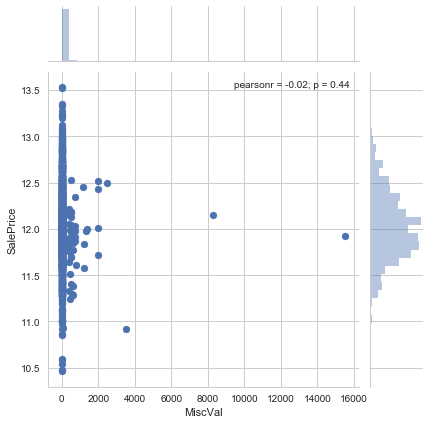

<  LowQualFinSF  >
-0.03796280313742792


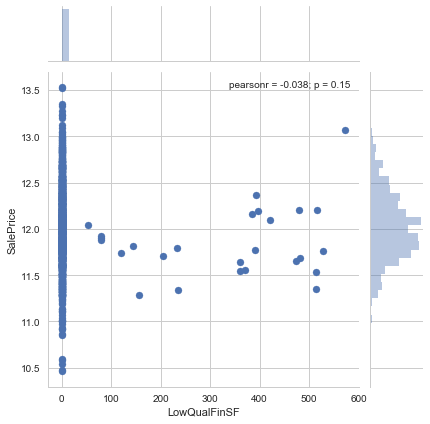

<  EnclosedPorch  >
-0.1490502814276759


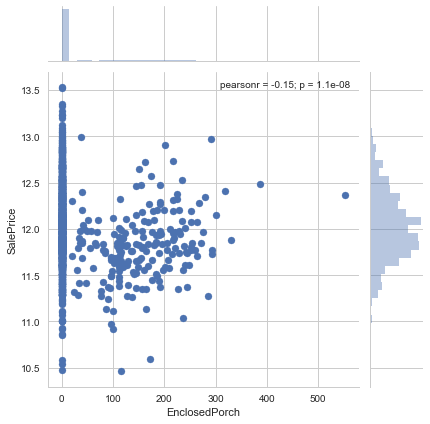

In [31]:
# 이 아래로는 모두 y에 log 붙인 거

corr = df.corr()['SalePrice']
df_corr = pd.DataFrame({"col" : num_ls})
df_corr['corr'] = df_corr['col'].apply(lambda x : corr[x])
df_corr.sort_values('corr', ascending=False, inplace=True)
num_ls2 = df_corr['col'].values

for col_name in num_ls2:
    print("< ",col_name," >")
    print(corr[col_name])
    sns.jointplot(x=col_name, y="SalePrice", data=df)
    plt.show()


#### TotSF 라는 변수 만들어줌 = 집의 총넓이

### 상관계수 구함
카테고리, 실수 값 상관없이 모두 구함

In [35]:
df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.817184
TotSF            0.777296
GrLivArea        0.700927
GarageCars       0.680625
ExterQual        0.678840
KitchenQual      0.667893
GarageArea       0.650888
BsmtQual         0.615804
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
FireplaceQu      0.546362
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
HeatingQC        0.473762
MasVnrArea       0.426775
BsmtFinSF1       0.372023
GarageQual       0.363259
GarageCond       0.356767
GarageYrBlt      0.349014
BsmtFinType1     0.334803
WoodDeckSF       0.334135
LotFrontage      0.323534
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
BsmtCond         0.274543
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolQC           0.077291
PoolArea         0.069798
MoSold           0.057329
3SsnPorch   

# 하나하나 대조해가면서 변수를 살펴봄.

In [43]:
str_cat_ls = list(set(cat_ls) - set(df.corr()['SalePrice'].index))

In [44]:
for col_name in str_cat_ls:
    print(df.groupby([col_name]).size(), "\n\n")

PavedDrive
N      90
P      30
Y    1340
dtype: int64 


Condition2
Artery       2
Feedr        6
Norm      1445
PosA         1
PosN         2
RRAe         1
RRAn         1
RRNn         2
dtype: int64 


SaleType
COD        43
CWD         4
Con         2
ConLD       9
ConLI       5
ConLw       5
New       122
Oth         3
WD       1267
dtype: int64 


Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      37
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgHt     77
OldTown    113
SWISU       25
Sawyer      74
SawyerW     59
Somerst     86
StoneBr     25
Timber      38
Veenker     11
dtype: int64 


BsmtExposure
Av    221
Gd    134
Mn    114
N      38
No    953
dtype: int64 


GarageFinish
Fin    352
N       81
RFn    422
Unf    605
dtype: int64 


Alley
Grvl      50
N       1369
Pave      41
dtype: int64 


LotShape
IR1    484
IR2     

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


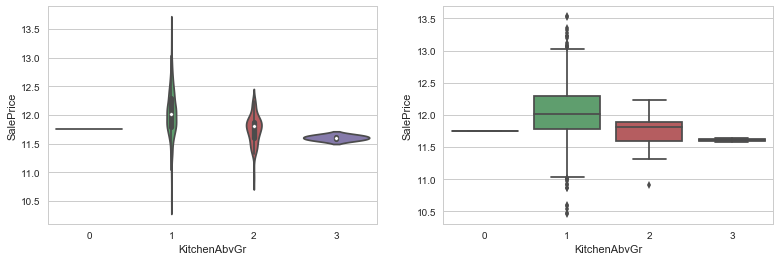

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


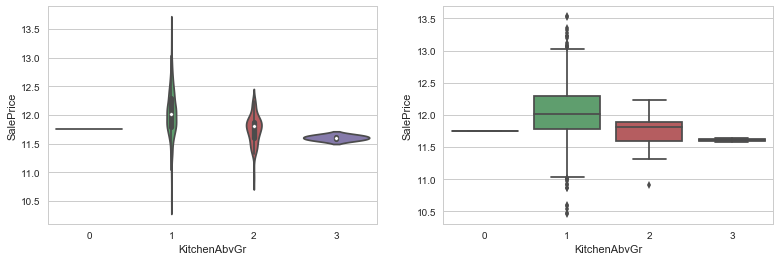

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


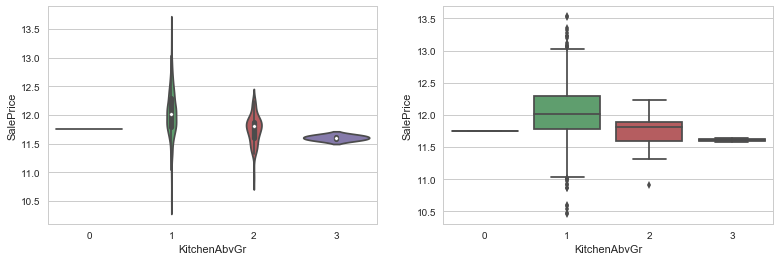

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


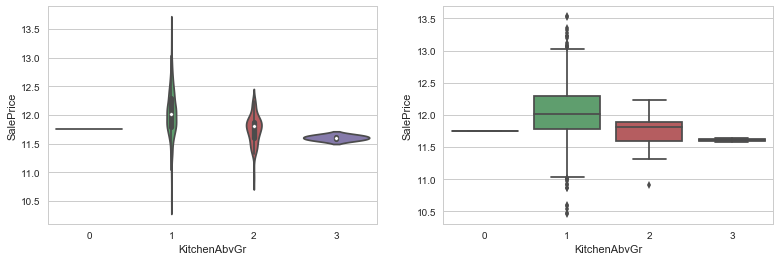

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


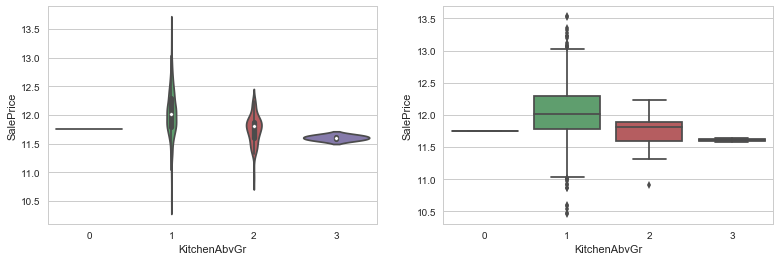

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


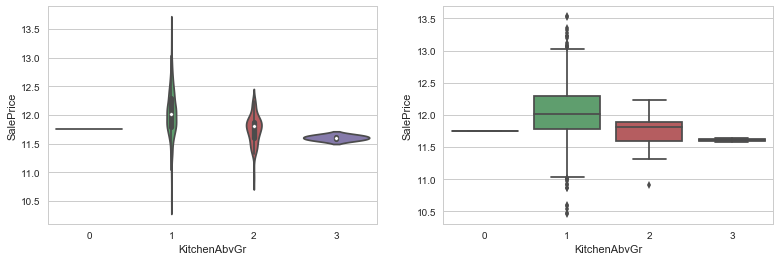

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


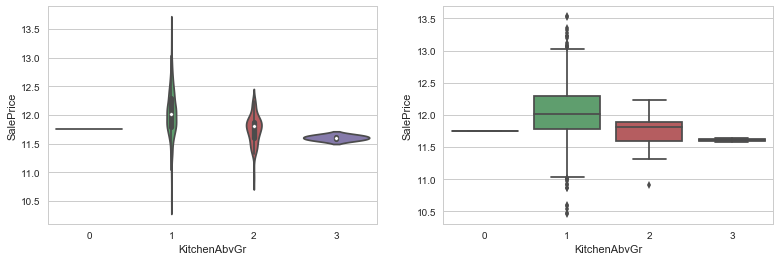

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


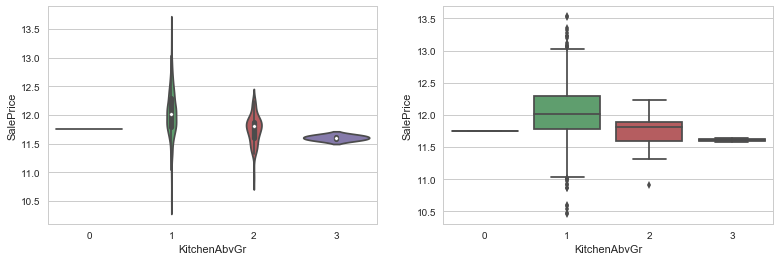

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


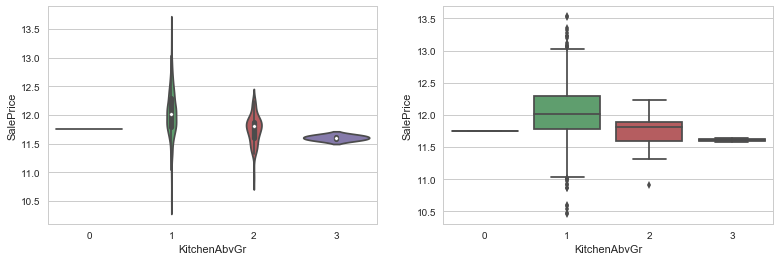

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


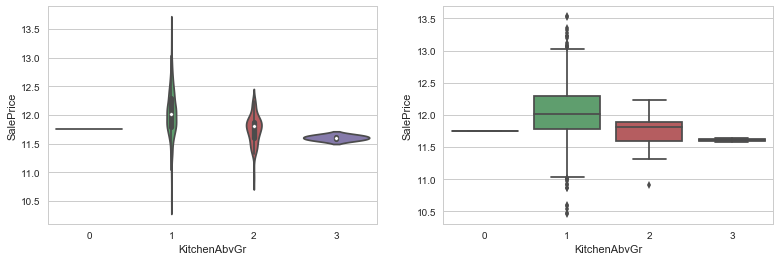

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


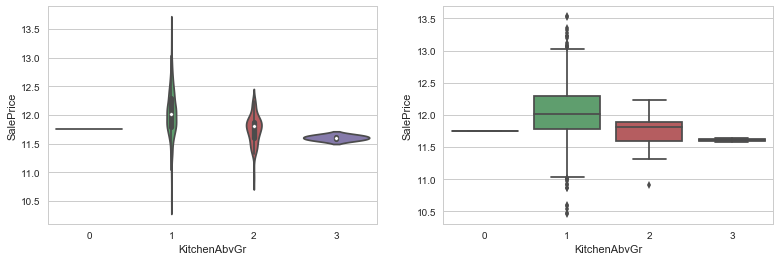

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


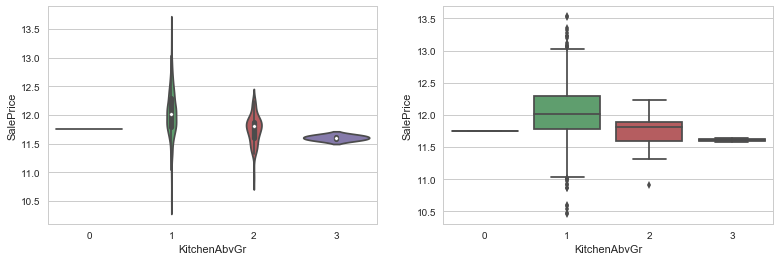

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


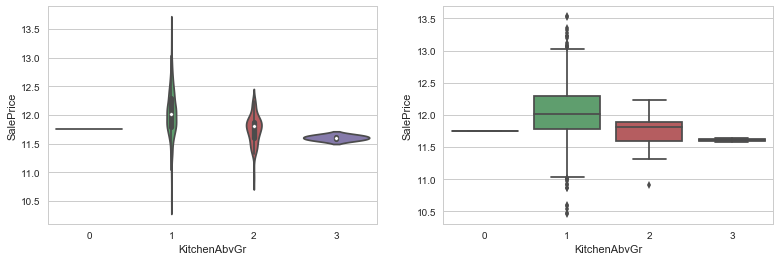

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


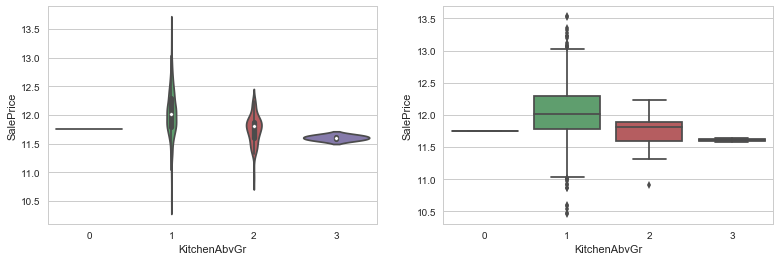

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


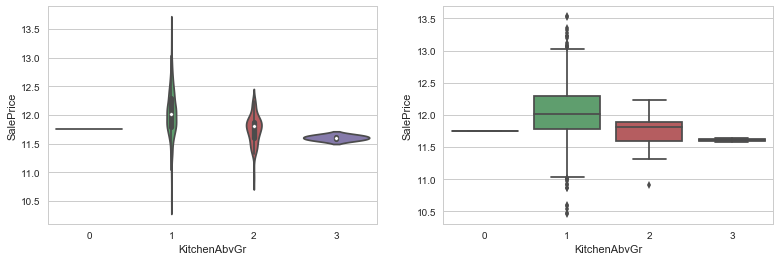

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


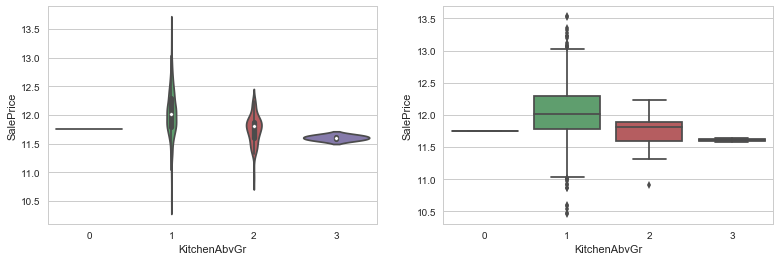

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


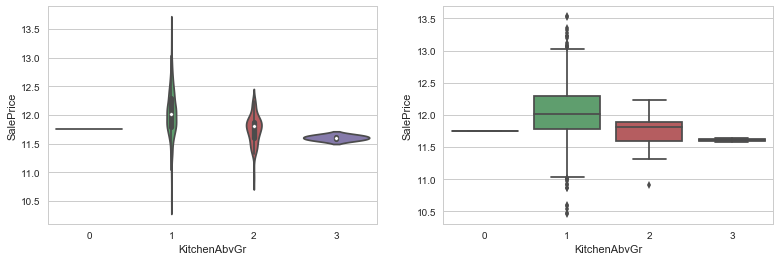

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


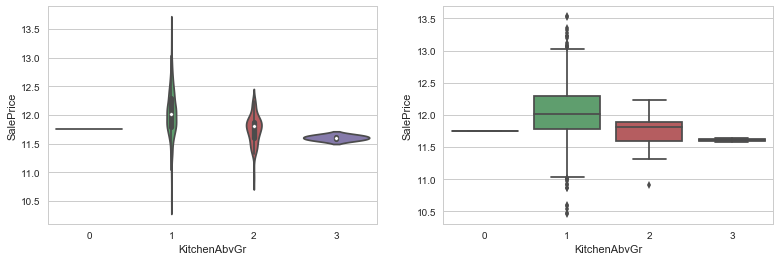

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


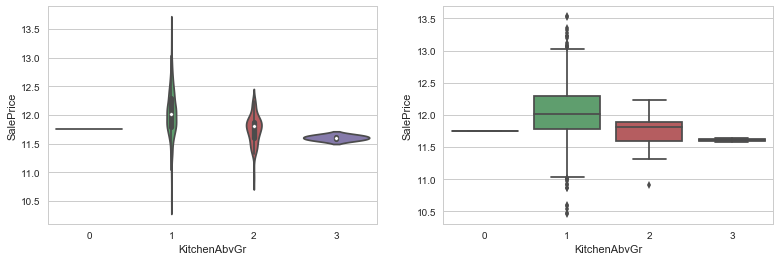

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


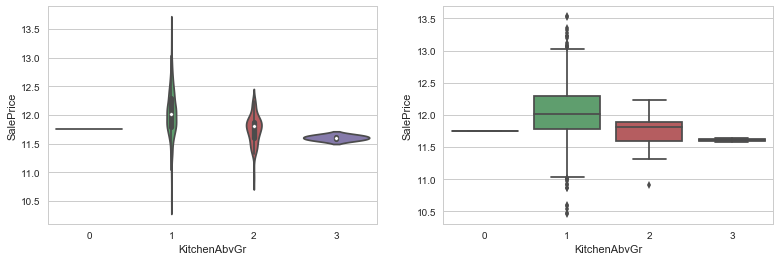

KitchenAbvGr
   KitchenAbvGr  Counts
0             0       1
1             1    1392
2             2      65
3             3       2


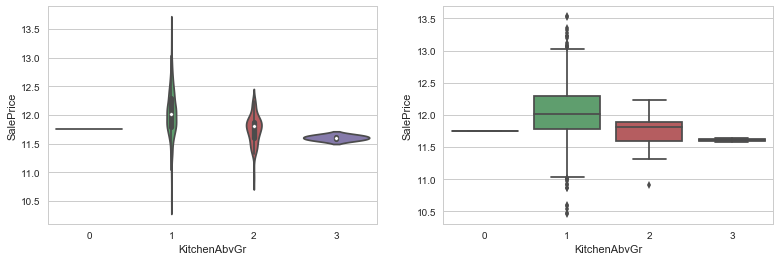

In [66]:
str_thou_ls = []
for col_name in str_cat_ls:
    if True in (df.groupby([col_name]).size().values > 1000):
        str_thou_ls.append(col_name)
        show_viobox(df, col)
        

In [62]:
str_thou_ls

['PavedDrive',
 'Condition2',
 'SaleType',
 'Alley',
 'RoofStyle',
 'CentralAir',
 'Electrical',
 'LandSlope',
 'BldgType',
 'LandContour',
 'SaleCondition',
 'MSZoning',
 'Utilities',
 'Functional',
 'Heating',
 'Street',
 'Fence',
 'Condition1',
 'LotConfig',
 'RoofMatl',
 'MiscFeature']

Foundation
  Foundation  Counts
0     BrkTil     146
1     CBlock     634
2      PConc     647
3       Slab      24
4      Stone       6
5       Wood       3


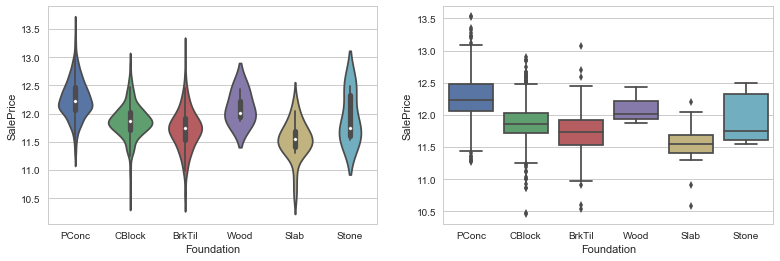

HouseStyle
  HouseStyle  Counts
0     1.5Fin     154
1     1.5Unf      14
2     1Story     726
3     2.5Fin       8
4     2.5Unf      11
5     2Story     445
6     SFoyer      37
7       SLvl      65


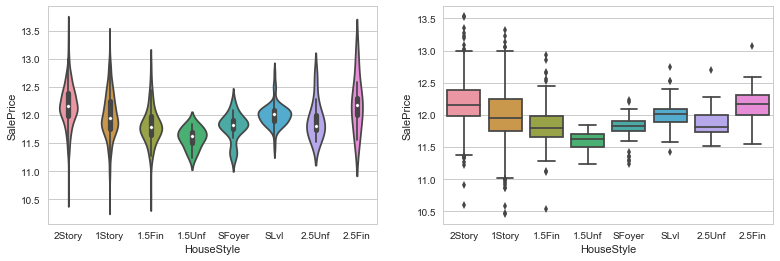

Neighborhood
   Neighborhood  Counts
0       Blmngtn      17
1       Blueste       2
2        BrDale      16
3       BrkSide      58
4       ClearCr      28
5       CollgCr     150
6       Crawfor      51
7       Edwards     100
8       Gilbert      79
9        IDOTRR      37
10      MeadowV      17
11      Mitchel      49
12        NAmes     225
13      NPkVill       9
14       NWAmes      73
15      NoRidge      41
16      NridgHt      77
17      OldTown     113
18        SWISU      25
19       Sawyer      74
20      SawyerW      59
21      Somerst      86
22      StoneBr      25
23       Timber      38
24      Veenker      11


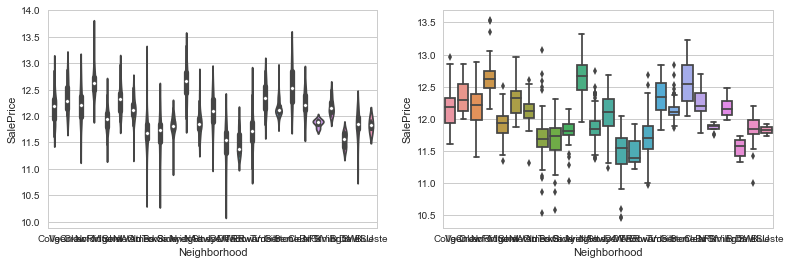

MasVnrType
  MasVnrType  Counts
0          0       8
1     BrkCmn      15
2    BrkFace     445
3       None     864
4      Stone     128


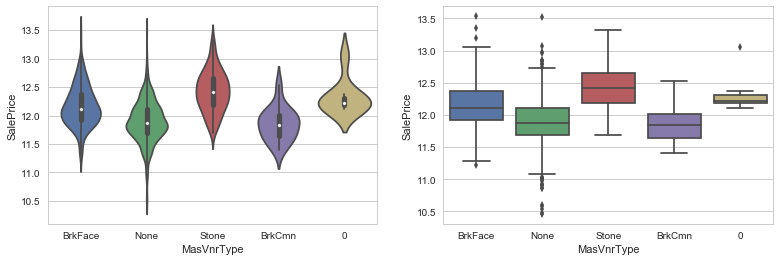

BsmtExposure
  BsmtExposure  Counts
0           Av     221
1           Gd     134
2           Mn     114
3            N      38
4           No     953


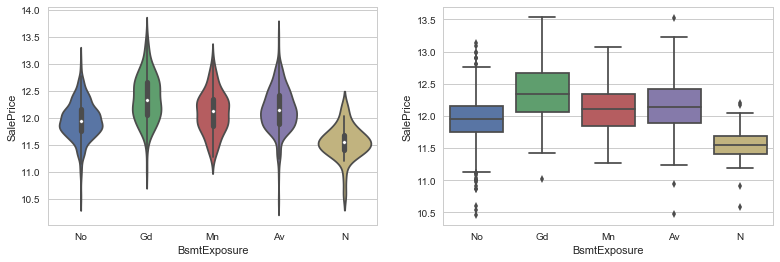

GarageFinish
  GarageFinish  Counts
0          Fin     352
1            N      81
2          RFn     422
3          Unf     605


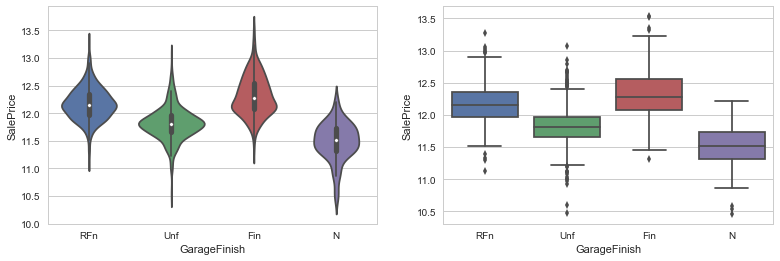

GarageType
  GarageType  Counts
0     2Types       6
1     Attchd     870
2    Basment      19
3    BuiltIn      88
4    CarPort       9
5     Detchd     387
6          N      81


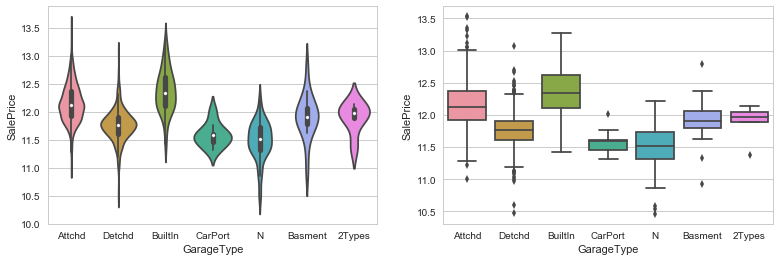

Exterior2nd
   Exterior2nd  Counts
0      AsbShng      20
1      AsphShn       3
2      Brk Cmn       7
3      BrkFace      25
4       CBlock       1
5      CmentBd      60
6      HdBoard     207
7      ImStucc      10
8      MetalSd     214
9        Other       1
10     Plywood     142
11       Stone       5
12      Stucco      26
13     VinylSd     504
14     Wd Sdng     197
15     Wd Shng      38


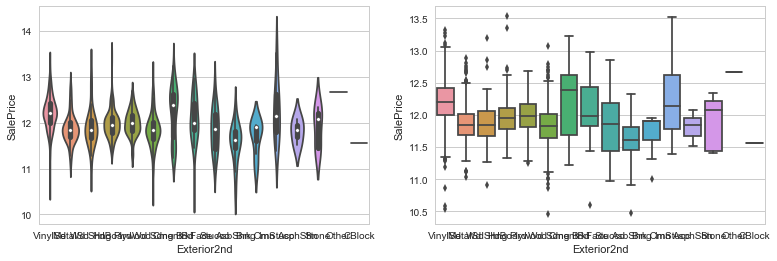

LotShape
  LotShape  Counts
0      IR1     484
1      IR2      41
2      IR3      10
3      Reg     925


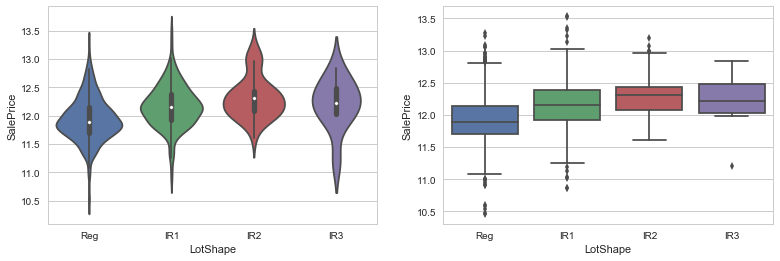

Exterior1st
   Exterior1st  Counts
0      AsbShng      20
1      AsphShn       1
2      BrkComm       2
3      BrkFace      50
4       CBlock       1
5      CemntBd      61
6      HdBoard     222
7      ImStucc       1
8      MetalSd     220
9      Plywood     108
10       Stone       2
11      Stucco      25
12     VinylSd     515
13     Wd Sdng     206
14     WdShing      26


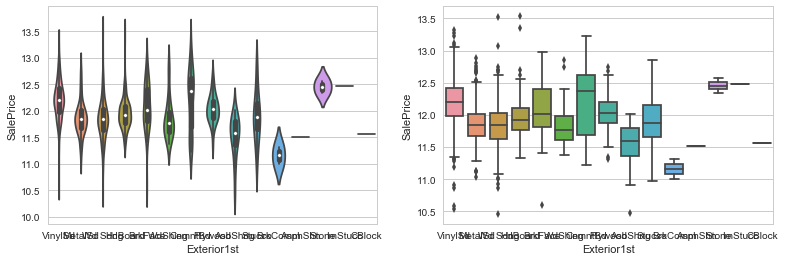

In [67]:
str_cat_ls2 = list(set(str_cat_ls) - set(str_thou_ls))

plt.rcParams["figure.figsize"] = (13,4)
for col in str_cat_ls2:
    show_viobox(df, col)

In [68]:
str_cat_ls2

['Foundation',
 'HouseStyle',
 'Neighborhood',
 'MasVnrType',
 'BsmtExposure',
 'GarageFinish',
 'GarageType',
 'Exterior2nd',
 'LotShape',
 'Exterior1st']

# f-test, ANOVA, R-squared

R^2 높은 변수 선택

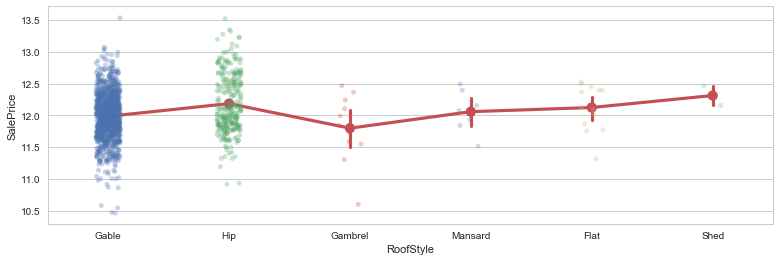

In [152]:
a = 'RoofStyle'

sns.stripplot(x=a, y="SalePrice", data=df, jitter=True, alpha=.3)
sns.pointplot(x=a, y="SalePrice", data=df, dodge=True, color='r')
plt.show()
model = sm.OLS.from_formula("SalePrice ~ C({}) + 0".format(a), data=df)
result = model.fit()
f_test = sm.stats.anova_lm(model.fit()).product()

In [153]:
f_test

df         8.724000e+03
sum_sq     4.702479e+07
mean_sq    5.390279e+03
F          2.296342e+05
PR(>F)     0.000000e+00
dtype: float64

In [155]:
print(result.rsquared_adj)

0.03980714304586974


In [159]:
cols = ['RoofStyle', 'CentralAir', 'BldgType', 'LandContour', 'SaleCondition', 'MSZoning', 'Fence', 'LotConfig', 'Foundation', 'HouseStyle', 'Neighborhood', 'MasVnrType', 'BsmtExposure', 'GarageFinish', 'GarageType', 'Exterior2nd', 'LotShape', 'Exterior1st']
anova_test = pd.DataFrame(columns=['col_name', 'f-test', 'rs', 'rs_a'])
for x1 in cols:
    model = sm.OLS.from_formula("SalePrice ~ C({}) + 0".format(x1), data=df)
    
    f_test = sm.stats.anova_lm(model.fit()).product()[4]
    
    result = model.fit()
    rs = result.rsquared
    rs_a = result.rsquared_adj
    
    anova_test = anova_test.append({'col_name': x1, 'f-test':f_test, 'rs':rs, 'rs_a':rs_a}, ignore_index=True)
    
anova_test.sort_values('rs', ascending=False)

,col_name,f-test,rs,rs_a
10,Neighborhood,0.0,0.570808,0.563630
13,GarageFinish,0.0,0.381034,0.379758
14,GarageType,0.0,0.334639,0.331892
8,Foundation,0.0,0.303651,0.301257
11,MasVnrType,0.0,0.194503,0.192289
17,Exterior1st,0.0,0.181531,0.173601
5,MSZoning,0.0,0.175839,0.173573
15,Exterior2nd,0.0,0.171463,0.162856
12,BsmtExposure,0.0,0.142594,0.140237
4,SaleCondition,0.0,0.129020,0.126025


In [161]:
anova_test = pd.DataFrame(columns=['col_name', 'f-test', 'rs', 'rs_a'])
for x1 in str_cat_ls:
    model = sm.OLS.from_formula("SalePrice ~ C({}) + 0".format(x1), data=df)
    
    f_test = sm.stats.anova_lm(model.fit()).product()[4]
    
    result = model.fit()
    rs = result.rsquared
    rs_a = result.rsquared_adj
    
    anova_test = anova_test.append({'col_name': x1, 'f-test':f_test, 'rs':rs, 'rs_a':rs_a}, ignore_index=True)
    
anova_test.sort_values('rs', ascending=False).reset_index()

,index,col_name,f-test,rs,rs_a
0,3,Neighborhood,0.0,0.570808,0.563630
1,5,GarageFinish,0.0,0.381034,0.379758
2,14,GarageType,0.0,0.334639,0.331892
3,28,Foundation,0.0,0.303651,0.301257
4,29,MasVnrType,0.0,0.194503,0.192289
5,17,Exterior1st,0.0,0.181531,0.173601
6,18,MSZoning,0.0,0.175839,0.173573
7,16,Exterior2nd,0.0,0.171463,0.162856
8,4,BsmtExposure,0.0,0.142594,0.140237
9,15,SaleCondition,0.0,0.129020,0.126025


# OLS

In [182]:
df_all = df.copy()
# model_all = sm.OLS.from_formula("SalePrice ~ OverallQual + TotSF + GrLivArea + GarageCars + ExterQual + KitchenQual + GarageArea + BsmtQual + YearBuilt + YearRemodAdd + FireplaceQu + TotRmsAbvGrd + Fireplaces + HeatingQC + MasVnrArea", data = df)
# ExterQual, FireplaceQu, MasVnrArea 제외

# model_all = sm.OLS.from_formula("SalePrice ~ OverallQual + TotSF + GrLivArea + GarageCars + KitchenQual + GarageArea + BsmtQual + YearBuilt + YearRemodAdd + TotRmsAbvGrd + Fireplaces + HeatingQC ", data = df)

# 스케일링
# model_all = sm.OLS.from_formula("SalePrice ~ scale(I(OverallQual**2)) + scale(I(OverallQual)) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(GarageArea) + scale(BsmtQual) + scale(YearBuilt) + scale(YearRemodAdd) + scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all)

#문자 포함
# model_all = sm.OLS.from_formula("SalePrice ~ C(CentralAir) + C(BldgType) + C(LandContour) + C(SaleCondition) + C(MSZoning) + C(Foundation) + C(Neighborhood) + C(LotShape) + scale(I(OverallQual**2)) + scale(I(OverallQual)) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(GarageArea) + scale(BsmtQual) + scale(YearBuilt) + scale(YearRemodAdd) + scale(TotRmsAbvGrd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all)

# model_all = sm.OLS.from_formula("SalePrice ~ C(CentralAir) + C(BldgType) + C(LandContour) + C(SaleCondition) + C(MSZoning) + C(Foundation) + C(Neighborhood) + C(LotShape) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearBuilt) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all)

# YearBtYear제거
# model_all = sm.OLS.from_formula("SalePrice ~ C(CentralAir) + C(BldgType) + C(LandContour) + C(SaleCondition) + C(MSZoning) + C(Foundation) + C(Neighborhood) + C(LotShape) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all)

# r-squared 값을 기준으로 카테고리 고름
model_all = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(I(OverallQual**3)) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all)


result_all = model_all.fit()
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     216.7
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        04:47:35   Log-Likelihood:                 747.44
No. Observations:                1460   AIC:                            -1407.
Df Residuals:                    1416   BIC:                            -1174.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [106]:
len(df_test)

1459

In [107]:
df_test['TotSF'] = df_test['1stFlrSF'] + df_test['TotalBsmtSF'] + df_test['2ndFlrSF']

In [166]:
pre = pd.DataFrame(result_all.predict(df_test))
pre['Id']=pre.index
pre = pre.rename(columns={0: 'SalePrice'})
pre['Id'] = range(1461,2920)
pre['SalePrice'] = pre['SalePrice'].apply(lambda x : np.exp(x))
pre.to_csv('submission.csv', index=False)

In [109]:
pre.describe()

,SalePrice,Id
count,1459.000000,1459.000000
mean,177098.450901,2190.000000
std,74509.458455,421.321334
min,40693.391516,1461.000000
25%,126364.024057,1825.500000
50%,158414.260946,2190.000000
75%,209320.763459,2554.500000
max,709043.460744,2919.000000


## 아웃라이어 제거

In [167]:
influence = result_all.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (1460 - 1 - 50)
idx = np.where(cooks_d2 > fox_cr)[0]
idx = list(set(idx) - set([599, 956]))
df_all2 = df_all.copy()
df_all2 = df_all2.drop(df_all2.index[idx])

In [191]:
model_all2 = sm.OLS.from_formula("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(I(OverallQual**3)) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", data = df_all2)

result_all2 = model_all2.fit()
print(result_all2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     353.3
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        05:00:55   Log-Likelihood:                 1145.2
No. Observations:                1392   AIC:                            -2202.
Df Residuals:                    1348   BIC:                            -1972.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [202]:
pre = pd.DataFrame(result_all2.predict(df_test))
pre['Id']=pre.index
pre = pre.rename(columns={0: 'SalePrice'})
pre['Id'] = range(1461,2920)
pre['SalePrice'] = pre['SalePrice'].apply(lambda x : np.exp(x))
pre.to_csv('submission.csv', index=False)

# VIF

In [230]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

ls = ['OverallQual', 'TotSF', 'GrLivArea', 'GarageCars', 'KitchenQual', 'BsmtQual', 'YearRemodAdd', 'Fireplaces', 'HeatingQC']
df_vif = df[ls]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["features"] = df_vif.columns
vif

,VIF Factor,features
0,64.335623,OverallQual
1,63.961497,TotSF
2,45.145334,GrLivArea
3,11.211861,GarageCars
4,61.466968,KitchenQual
5,33.737973,BsmtQual
6,39.714356,YearRemodAdd
7,2.550414,Fireplaces
8,28.065304,HeatingQC


### GrLivArea 랑 TotSF 가 높긴함.

In [231]:
df_vif.corr()

,OverallQual,TotSF,GrLivArea,GarageCars,KitchenQual,BsmtQual,YearRemodAdd,Fireplaces,HeatingQC
OverallQual,1.000000,0.668155,0.593007,0.600671,0.673331,0.629379,0.550684,0.396765,0.457083
TotSF,0.668155,1.000000,0.874373,0.536413,0.502738,0.514299,0.342873,0.477765,0.306564
GrLivArea,0.593007,0.874373,1.000000,0.467247,0.420563,0.327956,0.287389,0.461679,0.254644
GarageCars,0.600671,0.536413,0.467247,1.000000,0.509810,0.449194,0.420622,0.300789,0.325347
KitchenQual,0.673331,0.502738,0.420563,0.509810,1.000000,0.510938,0.625316,0.256409,0.504228
BsmtQual,0.629379,0.514299,0.327956,0.449194,0.510938,1.000000,0.515013,0.229635,0.397169
YearRemodAdd,0.550684,0.342873,0.287389,0.420622,0.625316,0.515013,1.000000,0.112581,0.550017
Fireplaces,0.396765,0.477765,0.461679,0.300789,0.256409,0.229635,0.112581,1.000000,0.129689
HeatingQC,0.457083,0.306564,0.254644,0.325347,0.504228,0.397169,0.550017,0.129689,1.000000


# 교차검증

In [215]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

cv = KFold(30, shuffle=True)
y, X = dmatrices("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(I(OverallQual**3)) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", df_all2, return_type = 'dataframe' )


#poly = PolynomialFeatures(1)
model1_LR = LinearRegression().fit(X, y)
model1_ridge = Ridge().fit(X, y)
model1_lasso = Lasso().fit(X, y)
model1_EN = ElasticNet().fit(X, y)
                
cv = KFold(30, shuffle=True)
#cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)
print('[Original LR]')
print('score : ', cross_val_score(model1_LR, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)))

print('[Ridge]')
print('score : ', cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)))

print('\n[Lasso]')
print('score : ', cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)),'\n')
      #'std : ', np.std(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)))

print('\n[Elastic-net]')
print('score : ', cross_val_score(model1_EN, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)),'\n')
#      'std : ', np.std(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)))

[Original LR]
score :  [0.94522389 0.93916186 0.89189332 0.86435803 0.91535133 0.92088448
 0.91513909 0.91118632 0.93414784 0.91375732 0.90562008 0.8893009
 0.92467631 0.88893669 0.83389143 0.95034207 0.92580822 0.91900248
 0.86715695 0.89365268 0.91654705 0.92937661 0.89939848 0.92973372
 0.93693105 0.85672336 0.87555213 0.89515784 0.91491001 0.92657567] 
 mean :  0.9097590154815994 
std :  0.02333329824022054
[Ridge]
score :  [0.91594444 0.91026893 0.85896688 0.90588222 0.90022325 0.89832219
 0.88963006 0.93427029 0.81387475 0.94779945 0.89330052 0.90903233
 0.93539721 0.93716531 0.93245221 0.91943782 0.93738292 0.93776815
 0.92897642 0.91148683 0.84408978 0.91592803 0.90184221 0.87957412
 0.89754413 0.91337083 0.91667729 0.93582779 0.84395625 0.90105336] 
 mean :  0.9081261131894839 
std :  0.02791577480994488

[Lasso]
score :  [-1.36308026e-04 -9.69855251e-04 -2.11921092e-02 -1.55402893e-02
 -8.87441225e-04 -9.69281842e-04 -1.82705525e-03 -2.87440253e-06
 -2.09351974e-03 -5.7931128

In [255]:
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

cv = KFold(20, shuffle=True)
y, X = dmatrices("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(I(OverallQual**3)) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", df_all2, return_type = 'dataframe' )
y2, X2 = dmatrices("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", df_all2, return_type = 'dataframe' )
y3, X3 = dmatrices("SalePrice ~ C(GarageFinish) + C(Foundation) + scale(I(OverallQual**3)) + scale(I(OverallQual**2)) + scale(OverallQual) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", df_all2, return_type = 'dataframe' )
y4, X4 = dmatrices("SalePrice ~ C(Neighborhood) + C(GarageFinish) + C(Foundation) + scale(TotSF) + scale(GrLivArea) + scale(GarageCars) + scale(KitchenQual) + scale(BsmtQual) + scale(YearRemodAdd) + scale(Fireplaces) + scale(HeatingQC)", df_all2, return_type = 'dataframe' )


#poly = PolynomialFeatures(1)
model1_LR = LinearRegression().fit(X, y)
model1_LR2 = LinearRegression().fit(X2, y2)
model1_LR3 = LinearRegression().fit(X3, y3)
model1_LR4 = LinearRegression().fit(X4, y4)

                
cv = KFold(20, shuffle=True)
#cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)
print('[Original LR]')
print('score : ', cross_val_score(model1_LR, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)),'\n')

print('[Original LR2]')
print('score : ', cross_val_score(model1_LR2, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR2, X2, y2, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_LR2, X2, y2, scoring="r2", cv=cv)),'\n')

print('[Original LR3]')
print('score : ', cross_val_score(model1_LR3, X3, y3, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR3, X3, y3, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_LR3, X3, y3, scoring="r2", cv=cv)),'\n')

print('[Original LR4]')
print('score : ', cross_val_score(model1_LR4, X4, y4, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR4, X4, y4, scoring="r2", cv=cv)),'\n'
      'std : ', np.std(cross_val_score(model1_LR4, X4, y4, scoring="r2", cv=cv)),'\n')

[Original LR]
score :  [0.89054558 0.94012885 0.82183814 0.9333571  0.90328036 0.89868712
 0.92306967 0.90123155 0.90356128 0.93012506 0.91114541 0.90853994
 0.90662957 0.92514784 0.950717   0.92182781 0.91159875 0.89815175
 0.87477188 0.90498139] 
 mean :  0.9098550357803316 
std :  0.021078270772044837 

[Original LR2]
score :  [0.9304132  0.91303068 0.93434319 0.85735053 0.92931144 0.91021013
 0.93282272 0.92662518 0.93346715 0.88514831 0.82434357 0.93087825
 0.92630963 0.91206913 0.83843707 0.91826289 0.91162088 0.91898996
 0.90801354 0.88660831] 
 mean :  0.9084661678267073 
std :  0.02573219296381414 

[Original LR3]
score :  [0.921017   0.881077   0.86413123 0.85584825 0.90452509 0.85205315
 0.9087987  0.9018749  0.86241152 0.89392884 0.89486291 0.91098059
 0.78560172 0.90522648 0.92553663 0.87341768 0.91280226 0.85879827
 0.91153709 0.88971203] 
 mean :  0.8870511051085858 
std :  0.029836171067967203 

[Original LR4]
score :  [0.89745746 0.86411025 0.88768055 0.88541525 0.9150

# ridge 모형 돌려봄

In [253]:
result_ridge = model_all2.fit_regularized(alpha=0.01, L1_wt=0)
print(result_ridge.params.round(2))
print(result_all2.params.values.round(1))

[10.05  0.1   0.1   0.75  0.43  0.39  0.65  0.51  0.5   0.35  0.16  0.4
  0.48  0.14  0.44  0.36  0.4   0.62  0.52  0.42  0.35  0.37  0.34  0.43
  0.25  0.47  0.4   0.57  1.08  1.27  0.55  0.06  0.07  0.1   0.05 -0.
  0.04  0.11  0.04  0.02  0.02  0.04  0.06  0.02]
[11.9 -0.  -0.1  0.1  0.2  0.1  0.2  0.1  0.1 -0.  -0.1  0.1  0.1  0.
  0.1  0.2  0.2  0.   0.1  0.1  0.1  0.2  0.2  0.2  0.2 -0.1 -0.  -0.
  0.1  0.   0.1  0.   0.   0.3 -0.5  0.3  0.1  0.   0.   0.   0.   0.
  0.   0. ]


In [198]:
pre = pd.DataFrame(result_ridge.predict(df_test))
pre['Id']=pre.index
pre = pre.rename(columns={0: 'SalePrice'})
pre['Id'] = range(1461,2920)
pre['SalePrice'] = pre['SalePrice'].apply(lambda x : np.exp(x))
pre.to_csv('submission.csv', index=False)